# Import library

In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00


In [ ]:
from netCDF4 import Dataset
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import plotly.express as px
import os
import math

import numpy as np
from numpy import dstack

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional
from keras.models import load_model

# input data

In [ ]:
# import data iklim
df= xr.open_dataset('POWER_Point_Daily_20150101_20240331_007d4610S_111d3322E_LST (2).nc')

In [ ]:
# membuat data iklim menjadi dataframe
df = df.to_dataframe()

# data cleaning

In [ ]:
df.head()

T2MDEW        T2M  PRECTOTCORR    T2M_MIN  \
time       lat    lon                                                        
2015-01-01 -7.461 111.332199  23.020000  25.150000        17.98  22.820000   
2015-01-02 -7.461 111.332199  22.049999  24.250000        25.26  21.600000   
2015-01-03 -7.461 111.332199  22.209999  24.760000        27.35  21.770000   
2015-01-04 -7.461 111.332199  22.620001  24.930000         9.42  21.570000   
2015-01-05 -7.461 111.332199  22.760000  25.299999        16.35  22.450001   

                              WS2M         PS    T2M_MAX       RH2M  
time       lat    lon                                                
2015-01-01 -7.461 111.332199  0.66  98.320000  28.680000  88.559998  
2015-01-02 -7.461 111.332199  1.55  98.410004  27.639999  88.120003  
2015-01-03 -7.461 111.332199  1.73  98.470001  28.299999  86.500000  
2015-01-04 -7.461 111.332199  1.24  98.349998  29.010000  87.750000  
2015-01-05 -7.461 111.332199  1.33  98.349998  29.010000  86.620003

In [ ]:
#Transformasi Data
df = df.reset_index()
start_date = '2018-01-01'
df = df[df['time'] >= start_date]
df = df.drop(['lat', 'lon', 'WS2M', 'PRECTOTCORR', 'RH2M', 'T2M_MAX', 'T2M_MIN', 'T2MDEW', 'PS' ], axis=1)

In [ ]:
df

time        T2M
1096 2018-01-01  25.530001
1097 2018-01-02  24.459999
1098 2018-01-03  25.980000
1099 2018-01-04  25.260000
1100 2018-01-05  25.540001
...         ...        ...
3373 2024-03-27  26.330000
3374 2024-03-28  25.530001
3375 2024-03-29  26.660000
3376 2024-03-30  27.219999
3377 2024-03-31  27.090000

[2282 rows x 2 columns]

In [ ]:
#Cheking Missing Values
df.isnull().sum()

time    0
T2M     0
dtype: int64

In [ ]:
# Cheking Duplicated Values
df.duplicated().sum()

0

# Normalisasi data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2282 entries, 1096 to 3377
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2282 non-null   datetime64[ns]
 1   T2M     2282 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 44.6 KB


In [ ]:
scaler = MinMaxScaler()
scale_cols = ['T2M']
df_scaled = scaler.fit_transform(df[scale_cols])

# Konversi hasil normalisasi ke DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=scale_cols)

# Split Data

In [ ]:
def testsize(df_scaled):
    TEST_SIZE = 0.1
    dataset = df_scaled
    total_rows = len(dataset)
    split_index = int(total_rows * (1 - TEST_SIZE))
    train = df_scaled.iloc[:split_index]
    test = df_scaled.iloc[split_index:]
    return dataset, train, test

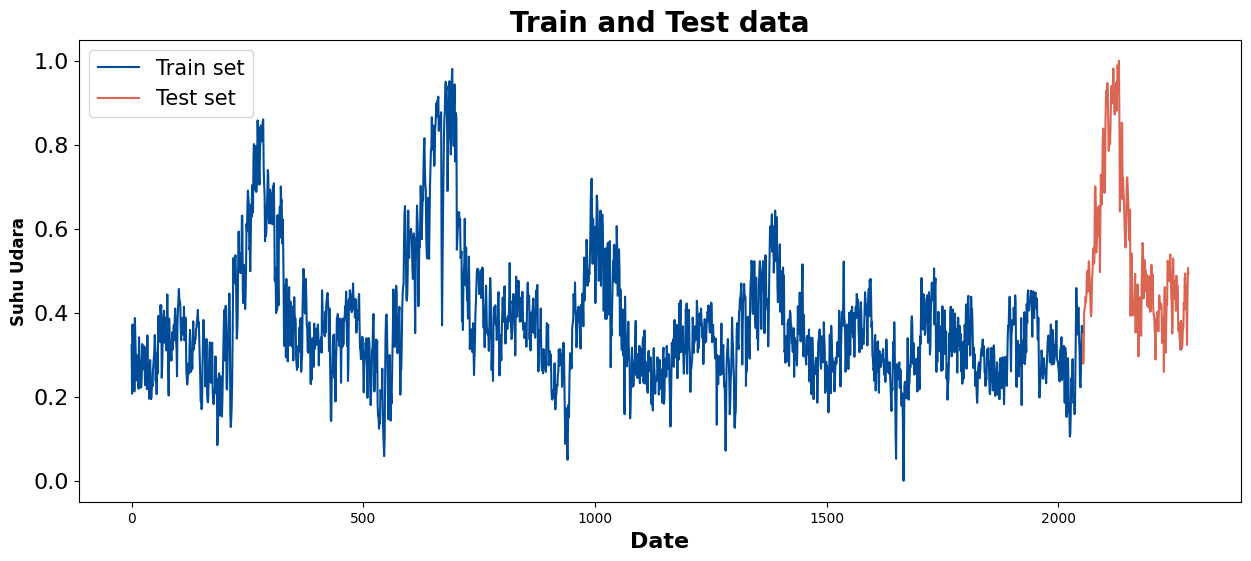

Dimension of train data:  (2053, 1)
Dimension of test data:  (229, 1)


In [ ]:
dataset, train, test = testsize(df_scaled)

#visualisasi
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(train['T2M'],color="#004C99")
ax.plot(test['T2M'],color="#D96552")
# Formatting
ax.set_title('Train and Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Suhu Udara', fontsize = 12, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
# plt.grid(b=False,axis = 'y')
# ax.grid(b=False,axis = 'y')
plt.legend(['Train set', 'Test set'], loc='upper left',prop={'size': 15})
# Simpan plot ke PDF
plt.savefig('train_test_plot.pdf', format='pdf')
plt.show()

print('Dimension of train data: ', train.shape)
print('Dimension of test data: ', test.shape)

# Modeling

In [ ]:
# fungsi untuk membuat dataset dengan window size tertentu
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
def train_and_evaluate(model, train_feature, train_label, test_feature, test_label, model_name):
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=5)
    filename = os.path.join('./', f'{model_name}.keras')
    checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=0, save_best_only=True, mode='auto')

    history = model.fit(train_feature, train_label, epochs=100, batch_size=32,
                       validation_data=(test_feature, test_label),
                       callbacks=[early_stop, checkpoint],
                       verbose=0)

    # Load best weights
    model.load_weights(filename)

    # Predict
    train_pred = model.predict(train_feature)
    test_pred = model.predict(test_feature)

    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    train_label = scaler.inverse_transform(train_label)
    test_label = scaler.inverse_transform(test_label)

    # Calculate metrics including MAPE
    metrics = {
        'Train MSE': mean_squared_error(train_label, train_pred),
        'Train RMSE': mean_squared_error(train_label, train_pred) ** 0.5,
        'Train MAE': mean_absolute_error(train_label, train_pred),
        'Train MAPE': mean_absolute_percentage_error(train_label, train_pred),
        'Train R-squared': r2_score(train_label, train_pred),
        'Test MSE': mean_squared_error(test_label, test_pred),
        'Test RMSE': mean_squared_error(test_label, test_pred) ** 0.5,
        'Test MAE': mean_absolute_error(test_label, test_pred),
        'Test MAPE': mean_absolute_percentage_error(test_label, test_pred),
        'Test R-squared': r2_score(test_label, test_pred),
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss.pdf', format='pdf')
    plt.show()

    # Save predictions to Excel
    df_train = pd.DataFrame({'Actual Training': train_label.flatten(), f'Predicted Training {model_name}': train_pred.flatten()})
    df_train.to_excel(f'{model_name}_trainpredictions.xlsx', index=False)
    df_test = pd.DataFrame({'Actual': test_label.flatten(), f'Predicted {model_name}': test_pred.flatten()})
    df_test.to_excel(f'{model_name}_predictions.xlsx', index=False)

## RNN

In [ ]:
def rnn(train, test, feature_cols, label_cols, window_size, units):
    train_feature, train_label = make_dataset(train[feature_cols], train[label_cols], window_size)
    test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], window_size)

    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(train_feature.shape[1], train_feature.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    train_and_evaluate(model, train_feature, train_label, test_feature, test_label, 'RNN')

## LSTM & BiLSTM

In [ ]:
def lstm(train, test, feature_cols, label_cols, window_size, units):
    train_feature, train_label = make_dataset(train[feature_cols], train[label_cols], window_size)
    test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], window_size)

    model = Sequential()
    model.add(LSTM(units, input_shape=(train_feature.shape[1], train_feature.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    train_and_evaluate(model, train_feature, train_label, test_feature, test_label, 'LSTM')

In [ ]:
def bilstm(train, test, feature_cols, label_cols, window_size, units):
    train_feature, train_label = make_dataset(train[feature_cols], train[label_cols], window_size)
    test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], window_size)

    model = Sequential()
    model.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=(train_feature.shape[1], train_feature.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    train_and_evaluate(model, train_feature, train_label, test_feature, test_label, 'BiLSTM')

## GRU & BiGRU

In [ ]:
def gru(train, test, feature_cols, label_cols, window_size, units):
    train_feature, train_label = make_dataset(train[feature_cols], train[label_cols], window_size)
    test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], window_size)

    model = Sequential()
    model.add(GRU(units, input_shape=(train_feature.shape[1], train_feature.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    train_and_evaluate(model, train_feature, train_label, test_feature, test_label, 'GRU')

In [ ]:
def bigru(train, test, feature_cols, label_cols, window_size, units):
    train_feature, train_label = make_dataset(train[feature_cols], train[label_cols], window_size)
    test_feature, test_label = make_dataset(test[feature_cols], test[label_cols], window_size)

    model = Sequential()
    model.add(Bidirectional(GRU(units, return_sequences=False), input_shape=(train_feature.shape[1], train_feature.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    train_and_evaluate(model, train_feature, train_label, test_feature, test_label, 'BiGRU')

## Stacking Ensemble LSTM & GRU

In [ ]:
# load models from file
def load_all_models():
    models = ['LSTM', 'GRU']

    all_models = []
    for model in models:
        filename = model + '.keras'
        model = load_model(filename)
        all_models.append(model)
    return all_models

In [ ]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(inputX):
    stackX = None
    models = load_all_models()
    for model in models:
      # make prediction
      yhat = model.predict(inputX, verbose=0)
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(inputX, inputy, window_size):
    # create dataset using ensemble
    stackedX = stacked_dataset(inputX)
    # fit standalone model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(stackedX, inputy[window_size:])
    return model

In [ ]:
# make a prediction with the stacked model
def stacked_lstm_gru(inputX, inputy, window_size):

    test_feature, test_label = make_dataset(inputX, inputy, window_size)
    model = fit_stacked_model(test_feature, inputy, window_size)
    # create dataset using ensemble
    stackedX = stacked_dataset(test_feature)
    # make a prediction
    ensemble_pred = model.predict(stackedX)

    ensemble_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1))
    test_label = scaler.inverse_transform(test_label.reshape(-1, 1))

    # calculate root mean squared error
    print("Metriks Evaluasi LSTM-GRU")
    metrics = {
        'Test MSE': mean_squared_error(ensemble_pred, test_label),
        'Test RMSE': mean_squared_error(ensemble_pred, test_label) ** 0.5,
        'Test MAE': mean_absolute_error(ensemble_pred, test_label),
        'Test MAPE': mean_absolute_percentage_error(ensemble_pred, test_label),
        'Test R-squared': r2_score(ensemble_pred, test_label),
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

     # Create DataFrame
    label_column_name = 'Actual'
    pred_column_name = 'predict stacking LSTM-GRU'

    df_stack = pd.DataFrame({label_column_name: test_label.flatten(), pred_column_name: ensemble_pred.flatten()})

    # Save DataFrame to Excel
    excel_filename = 'staking_predictions.xlsx'
    df_stack.to_excel(excel_filename, index=False)

## Stacking Ensemble BiLSTM & BiGRU

In [ ]:
# load models from file
def load_all_models2():
    models = ['BiLSTM', 'BiGRU']

    all_models = []
    for model in models:
        filename = model + '.keras'
        model = load_model(filename)
        all_models.append(model)
    return all_models

In [ ]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset2(inputX):
    stackX = None
    models = load_all_models2()
    for model in models:
      # make prediction
      yhat = model.predict(inputX, verbose=0)
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = yhat
      else:
        stackX = np.dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [ ]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model2(inputX, inputy, window_size):


    # create dataset using ensemble
    stackedX = stacked_dataset2(inputX)
    # fit standalone model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(stackedX, inputy[window_size:])
    return model

In [ ]:
# make a prediction with the stacked model
def stacked_bilstm_bigru(inputX, inputy, window_size):

    test_feature, test_label = make_dataset(inputX, inputy, window_size)
    model = fit_stacked_model2(test_feature, inputy, window_size)
    # create dataset using ensemble
    stackedX = stacked_dataset2(test_feature)
    # make a prediction
    ensemble_pred = model.predict(stackedX)

    ensemble_pred = scaler.inverse_transform(ensemble_pred.reshape(-1, 1))
    test_label = scaler.inverse_transform(test_label.reshape(-1, 1))

    # calculate root mean squared error
    print("Metriks Evaluasi BiLSTM-BiGRU")
    metrics = {
        'Test MSE': mean_squared_error(ensemble_pred, test_label),
        'Test RMSE': mean_squared_error(ensemble_pred, test_label) ** 0.5,
        'Test MAE': mean_absolute_error(ensemble_pred, test_label),
        'Test MAPE': mean_absolute_percentage_error(ensemble_pred, test_label),
        'Test R-squared': r2_score(ensemble_pred, test_label),
    }

    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Create DataFrame
    label_column_name = 'Actual'
    pred_column_name = 'predict stacking BiLSTM-BiGRU'

    df_stack2 = pd.DataFrame({label_column_name: test_label.flatten(), pred_column_name: ensemble_pred.flatten()})

    # Save DataFrame to Excel
    excel_filename = 'staking_predictions2.xlsx'
    df_stack2.to_excel(excel_filename, index=False)

# Hasil

In [ ]:
def run_all(train, test, feature_cols, label_cols, window_size, units):
    rnn(train, test, feature_cols, label_cols, window_size, units)
    lstm(train, test, feature_cols, label_cols, window_size, units)
    bilstm(train, test, feature_cols, label_cols, window_size, units)
    gru(train, test, feature_cols, label_cols, window_size, units)
    bigru(train, test, feature_cols, label_cols, window_size, units)
    stacked_lstm_gru(test[feature_cols], test[label_cols], window_size)
    stacked_bilstm_bigru(test[feature_cols], test[label_cols], window_size)

## Windows_size (7 hari)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE: 0.2915
Train RMSE: 0.5399
Train MAE: 0.4176
Train MAPE: 0.0161
Train R-squared: 0.8385
Test MSE: 0.3095
Test RMSE: 0.5564
Test MAE: 0.4276
Test MAPE: 0.0155
Test R-squared: 0.8931


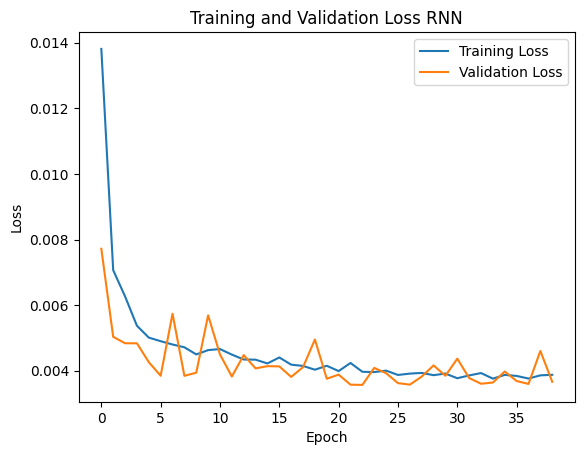

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.2972
Train RMSE: 0.5452
Train MAE: 0.4232
Train MAPE: 0.0163
Train R-squared: 0.8353
Test MSE: 0.3116
Test RMSE: 0.5582
Test MAE: 0.4293
Test MAPE: 0.0155
Test R-squared: 0.8924


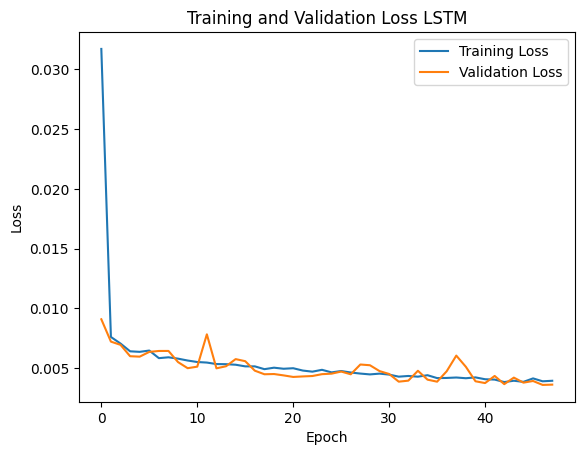

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.2862
Train RMSE: 0.5350
Train MAE: 0.4155
Train MAPE: 0.0160
Train R-squared: 0.8414
Test MSE: 0.3007
Test RMSE: 0.5484
Test MAE: 0.4248
Test MAPE: 0.0154
Test R-squared: 0.8962


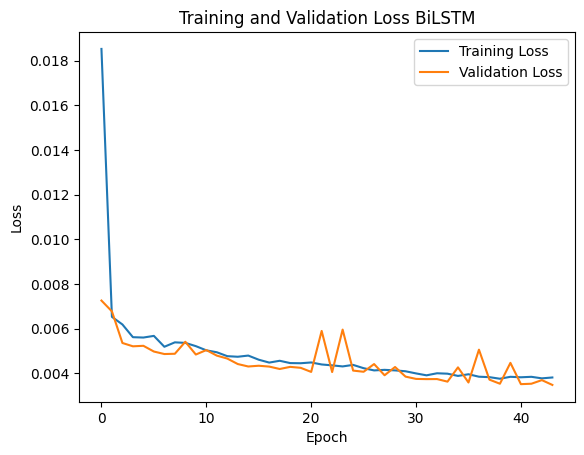

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.2827
Train RMSE: 0.5317
Train MAE: 0.4134
Train MAPE: 0.0159
Train R-squared: 0.8433
Test MSE: 0.3019
Test RMSE: 0.5495
Test MAE: 0.4237
Test MAPE: 0.0153
Test R-squared: 0.8958


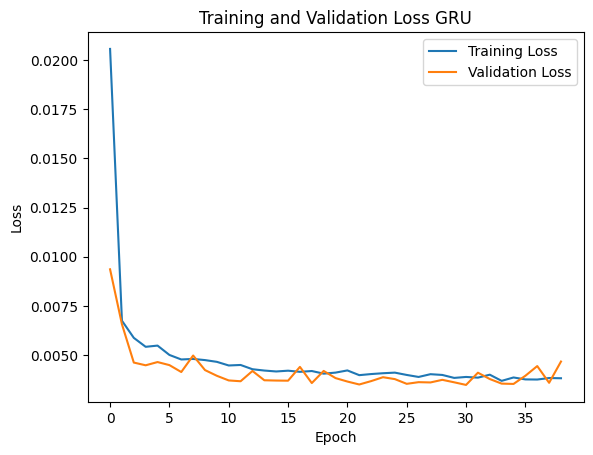

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.2832
Train RMSE: 0.5321
Train MAE: 0.4139
Train MAPE: 0.0159
Train R-squared: 0.8431
Test MSE: 0.3062
Test RMSE: 0.5533
Test MAE: 0.4291
Test MAPE: 0.0155
Test R-squared: 0.8943


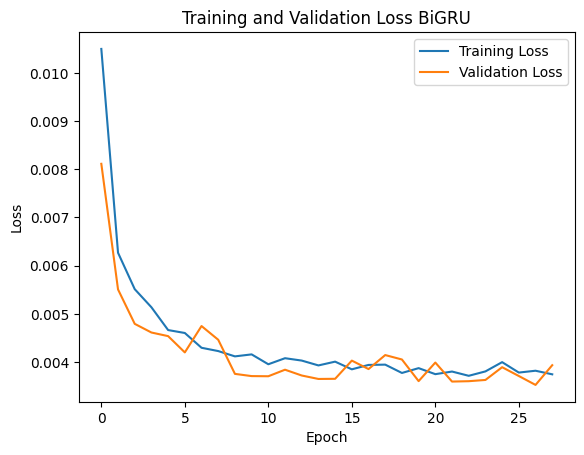

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi LSTM-GRU
Test MSE: 0.0494
Test RMSE: 0.2222
Test MAE: 0.1769
Test MAPE: 0.0064
Test R-squared: 0.9820


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi BiLSTM-BiGRU
Test MSE: 0.0463
Test RMSE: 0.2153
Test MAE: 0.1677
Test MAPE: 0.0061
Test R-squared: 0.9831


In [ ]:
feature_cols = ['T2M']
label_cols = ['T2M']

run_all(train, test, feature_cols, label_cols, 7, 50)

### Visualisasi Train

In [ ]:
df_rnn = pd.read_excel('/content/RNN_predictions.xlsx')
df_lstm = pd.read_excel('/content/LSTM_predictions.xlsx')
df_bilstm = pd.read_excel('/content/BiLSTM_predictions.xlsx')
df_gru = pd.read_excel('/content/GRU_predictions.xlsx')
df_bigru = pd.read_excel('/content/BiGRU_predictions.xlsx')
df_stack = pd.read_excel('/content/staking_predictions.xlsx')
df_stack2 = pd.read_excel('/content/staking_predictions2.xlsx')
train_rnn = pd.read_excel('/content/RNN_trainpredictions.xlsx')
train_lstm = pd.read_excel('/content/LSTM_trainpredictions.xlsx')
train_bilstm = pd.read_excel('/content/BiLSTM_trainpredictions.xlsx')
train_gru = pd.read_excel('/content/GRU_trainpredictions.xlsx')
train_bigru = pd.read_excel('/content/BiGRU_trainpredictions.xlsx')

In [ ]:
date_range = pd.date_range(start='2018-01-08', periods=len(train_lstm), freq='D')
train_rnn['date'] = date_range
train_lstm['date'] = date_range
train_bilstm['date'] = date_range
train_gru['date'] = date_range
train_bigru['date'] = date_range

In [ ]:
df_train = pd.merge(train_rnn, train_lstm)
df_train = pd.merge(df_train, train_bilstm)
df_train = pd.merge(df_train, train_gru)
df_train = pd.merge(df_train, train_bigru)
df_train['date']
df_train.head()

Actual Training  Predicted Training RNN       date  \
0        26.119999               24.885897 2018-01-08   
1        25.730001               25.988821 2018-01-09   
2        25.309999               25.764978 2018-01-10   
3        24.749998               25.490637 2018-01-11   
4        25.170000               25.045652 2018-01-12   

   Predicted Training LSTM  Predicted Training BiLSTM  Predicted Training GRU  \
0                25.065718                  24.946178               24.771040   
1                25.727850                  25.824148               25.961964   
2                25.728333                  25.701624               25.621126   
3                25.503695                  25.437550               25.374683   
4                25.160152                  25.094109               24.989414   

   Predicted Training BiGRU  
0                 24.803011  
1                 25.932329  
2                 25.715462  
3                 25.411373  
4                 25.019547

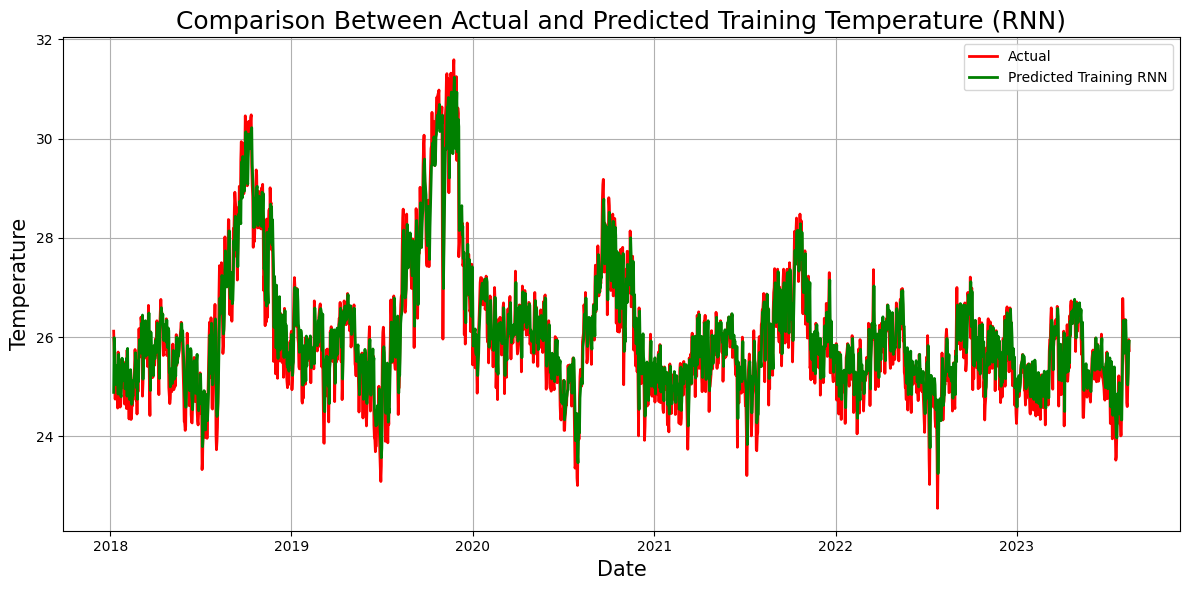

In [ ]:
# Plot data train RNN
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training RNN'], label='Predicted Training RNN', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (RNN)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN train.pdf', format='pdf')
plt.show()

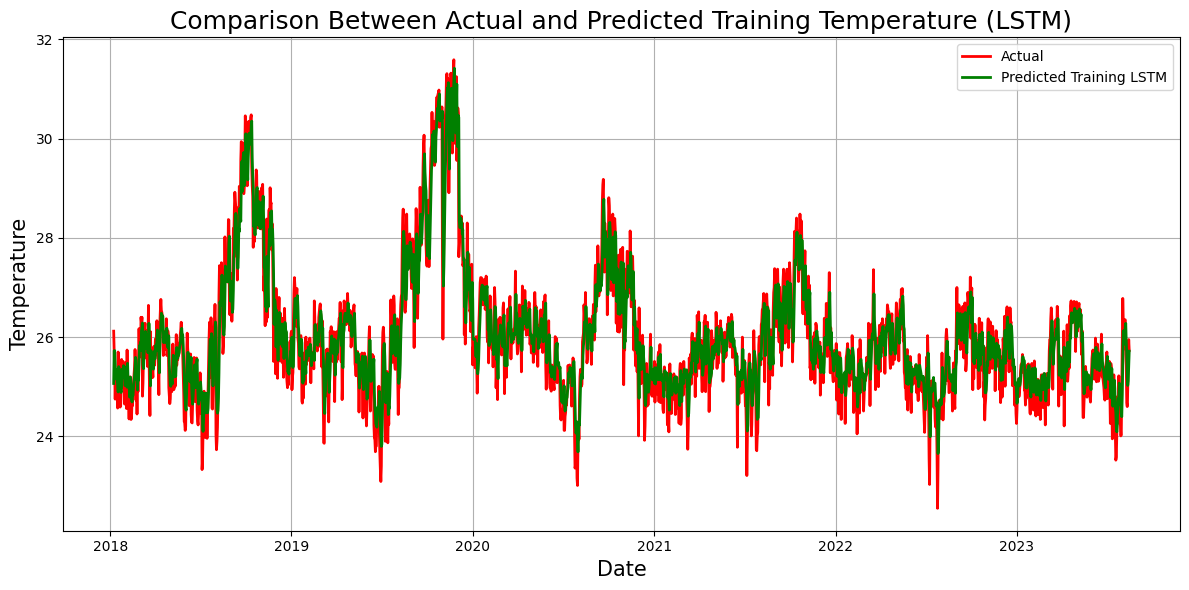

In [ ]:
# Plot data train LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training LSTM'], label='Predicted Training LSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (LSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM train.pdf', format='pdf')
plt.show()

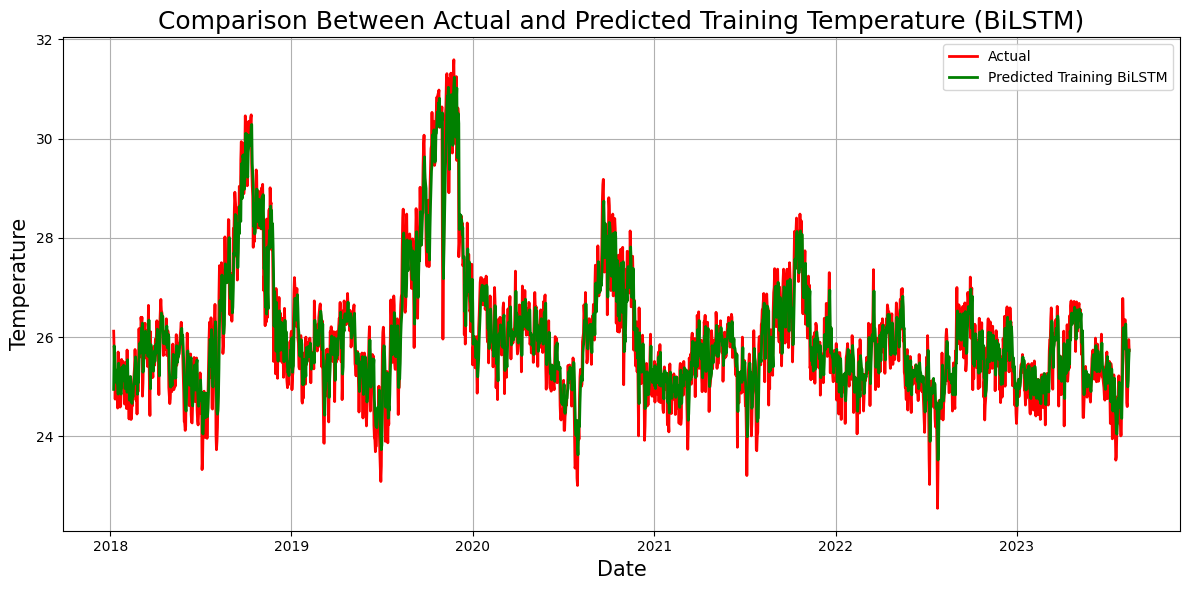

In [ ]:
# Plot data train BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiLSTM'], label='Predicted Training BiLSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiLSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM train.pdf', format='pdf')
plt.show()

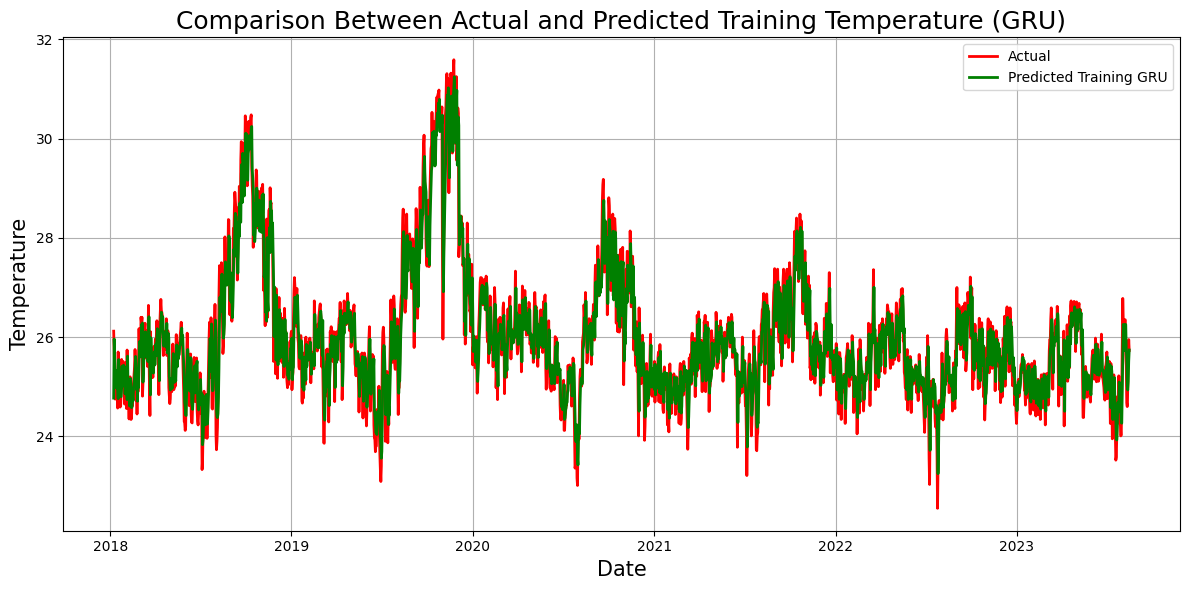

In [ ]:
# Plot data train GRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training GRU'], label='Predicted Training GRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (GRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU train.pdf', format='pdf')
plt.show()

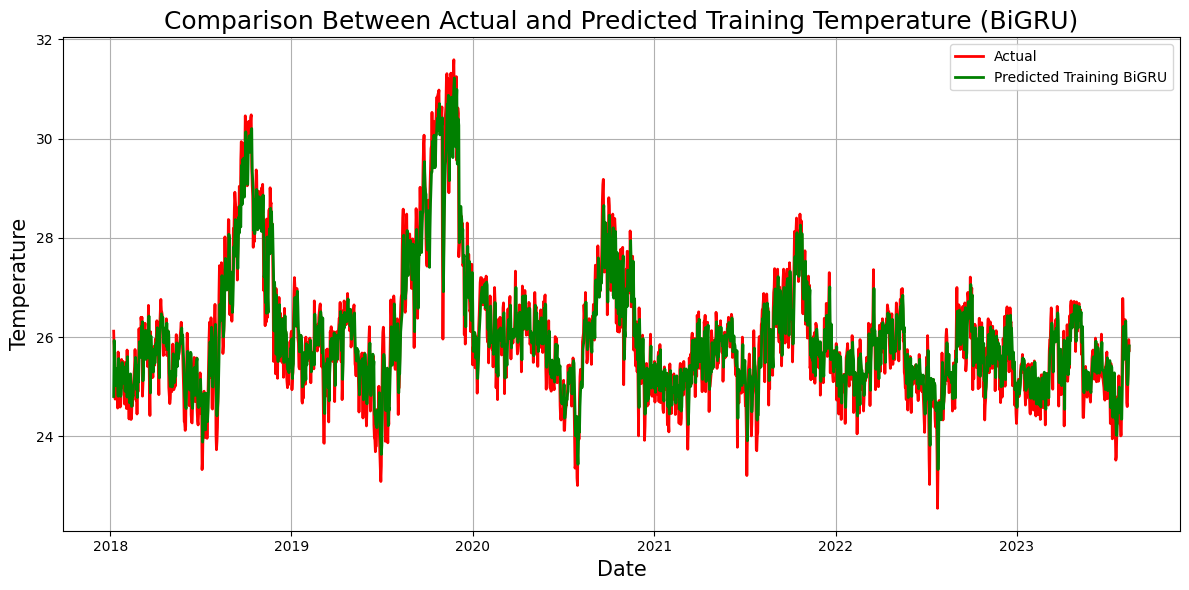

In [ ]:
# Plot data train BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiGRU'], label='Predicted Training BiGRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiGRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU train.pdf', format='pdf')
plt.show()

### Visualisasi prediksi


In [ ]:
date_range = pd.date_range(start='2023-08-23', periods=len(df_lstm), freq='D')
df_rnn['date'] = date_range
df_lstm['date'] = date_range
df_bilstm['date'] = date_range
df_gru['date'] = date_range
df_bigru['date'] = date_range
df_stack['date'] = date_range
df_stack2['date'] = date_range

In [ ]:
df_merge = pd.merge(df_rnn, df_lstm)
df_merge = pd.merge(df_merge, df_bilstm)
df_merge = pd.merge(df_merge, df_gru)
df_merge = pd.merge(df_merge, df_bigru)
df_merge = pd.merge(df_merge, df_stack)
df_merge = pd.merge(df_merge, df_stack2)
df_merge['date']
df_merge.head()

Actual  Predicted RNN       date  Predicted LSTM  Predicted BiLSTM  \
0  26.480000      26.501951 2023-08-23       26.380808         26.387781   
1  26.700001      26.361570 2023-08-24       26.382666         26.357882   
2  27.150000      26.582172 2023-08-25       26.540125         26.546629   
3  27.059999      27.021719 2023-08-26       26.861486         26.898014   
4  26.700001      26.969883 2023-08-27       26.898228         26.880226   

   Predicted GRU  Predicted BiGRU  predict stacking LSTM-GRU  \
0      26.398869        26.360834                    26.5054   
1      26.350454        26.290606                    26.4860   
2      26.572844        26.542593                    26.9176   
3      26.933815        26.939363                    27.0100   
4      26.864239        26.875109                    26.8112   

   predict stacking BiLSTM-BiGRU  
0                        26.4296  
1                        26.6652  
2                        26.9200  
3                        27.0656  
4                        26.7300

In [ ]:
df_merge = df_merge[['date', 'Actual','Predicted RNN', 'Predicted LSTM', 'Predicted BiLSTM', 'Predicted GRU', 'Predicted BiGRU', 'predict stacking LSTM-GRU','predict stacking BiLSTM-BiGRU']]
df_merge = df_merge.rename(columns={'Predicted RNN':'predict RNN', 'Predicted LSTM' : 'predict LSTM', 'Predicted BiLSTM' : 'predict BiLSTM', 'Predicted GRU' : 'predict GRU', 'Predicted BiGRU' : 'predict BiGRU'})

df_merge.head()

date     Actual  predict RNN  predict LSTM  predict BiLSTM  \
0 2023-08-23  26.480000    26.501951     26.380808       26.387781   
1 2023-08-24  26.700001    26.361570     26.382666       26.357882   
2 2023-08-25  27.150000    26.582172     26.540125       26.546629   
3 2023-08-26  27.059999    27.021719     26.861486       26.898014   
4 2023-08-27  26.700001    26.969883     26.898228       26.880226   

   predict GRU  predict BiGRU  predict stacking LSTM-GRU  \
0    26.398869      26.360834                    26.5054   
1    26.350454      26.290606                    26.4860   
2    26.572844      26.542593                    26.9176   
3    26.933815      26.939363                    27.0100   
4    26.864239      26.875109                    26.8112   

   predict stacking BiLSTM-BiGRU  
0                        26.4296  
1                        26.6652  
2                        26.9200  
3                        27.0656  
4                        26.7300

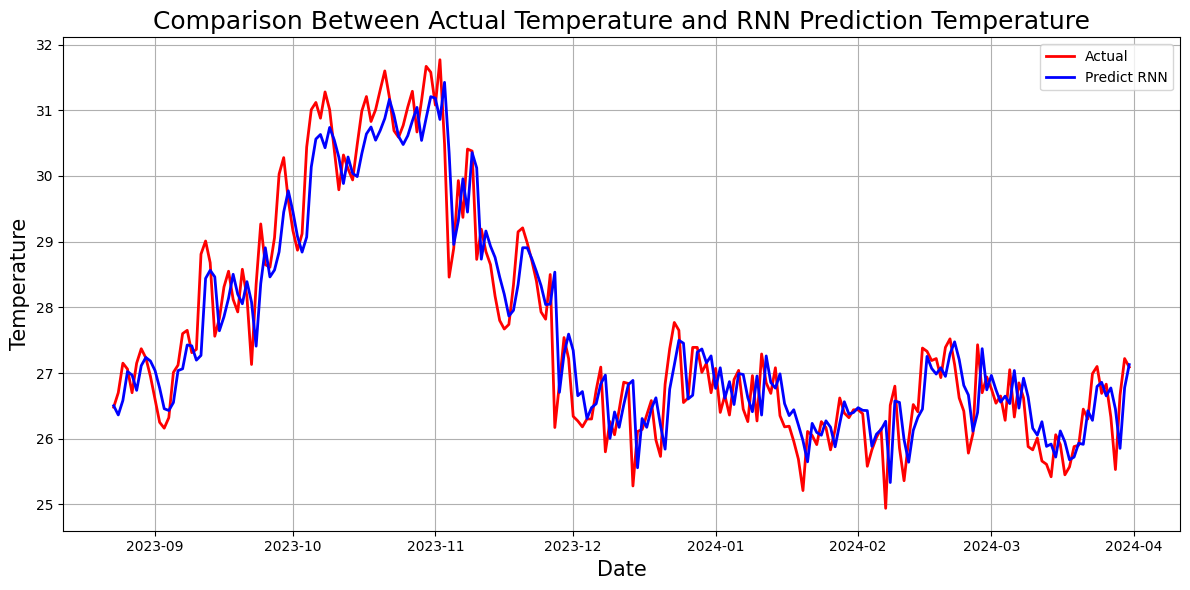

In [ ]:
# Plot data test RNN
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict RNN'], label='Predict RNN', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and RNN Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN.pdf', format='pdf')
plt.show()

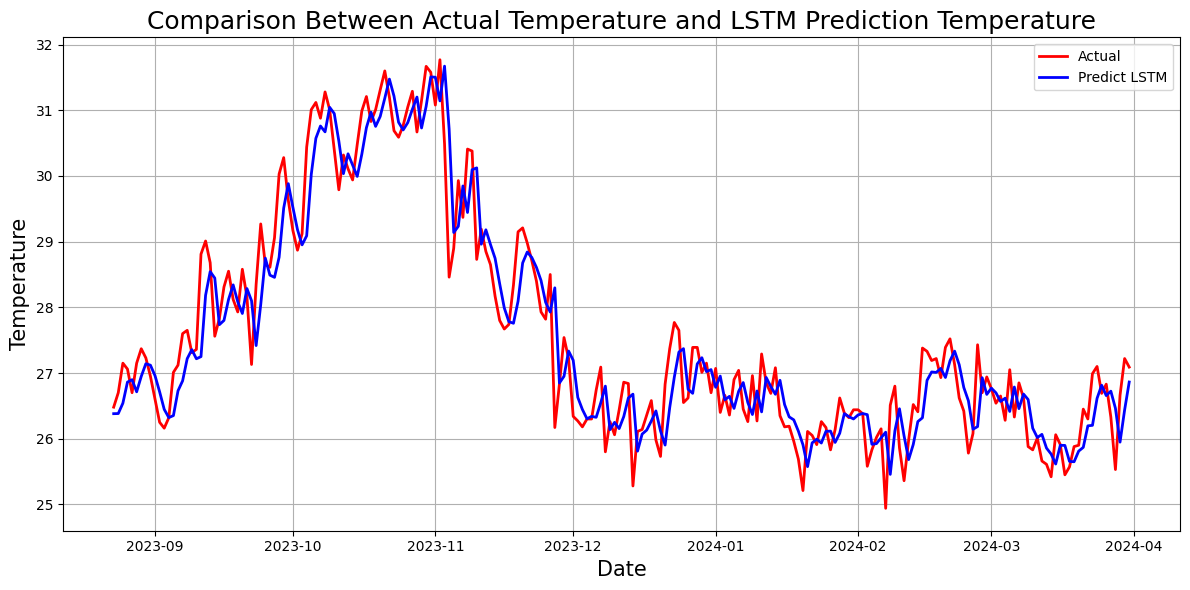

In [ ]:
# Plot data test LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict LSTM'], label='Predict LSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and LSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM.pdf', format='pdf')
plt.show()

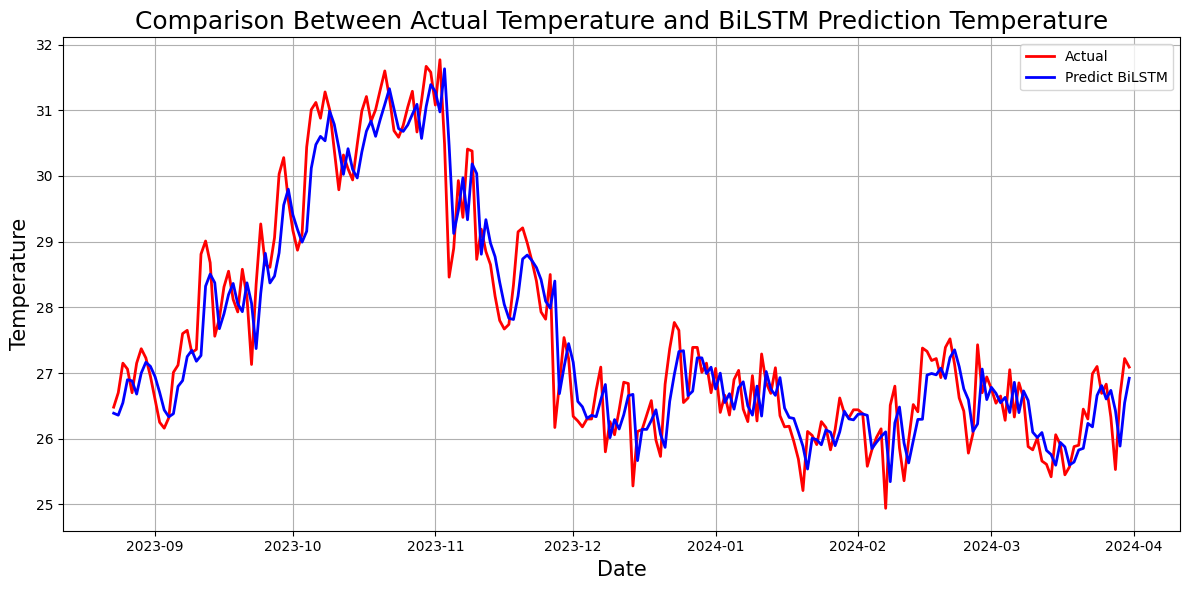

In [ ]:
# Plot data test BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiLSTM'], label='Predict BiLSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiLSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM.pdf', format='pdf')
plt.show()

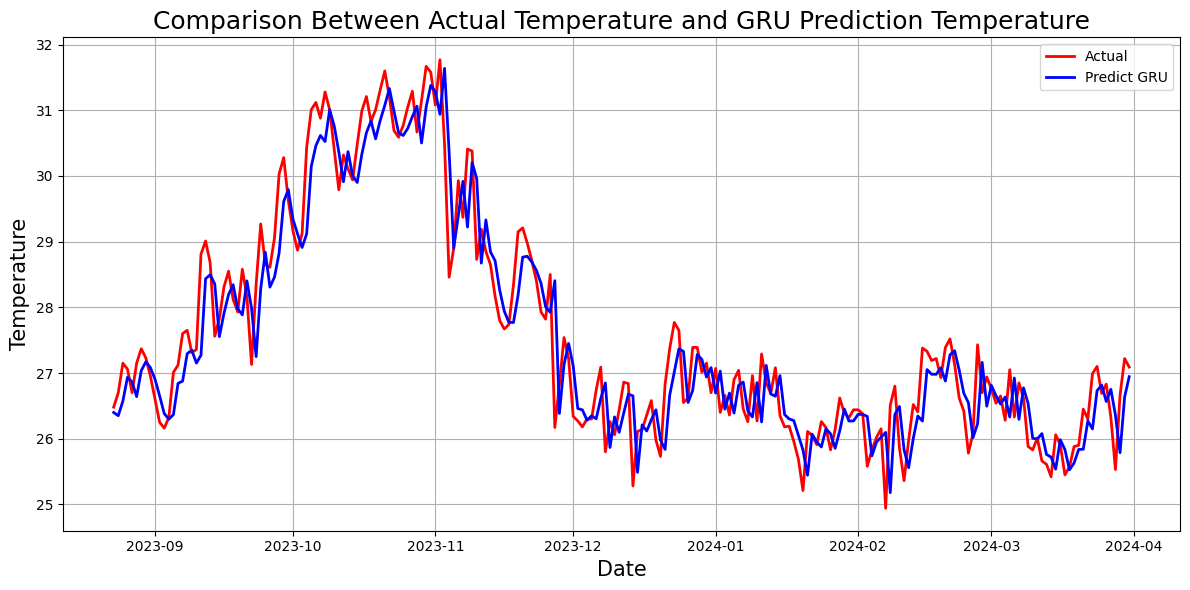

In [ ]:
# Plot data test GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict GRU'], label='Predict GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU.pdf', format='pdf')
plt.show()

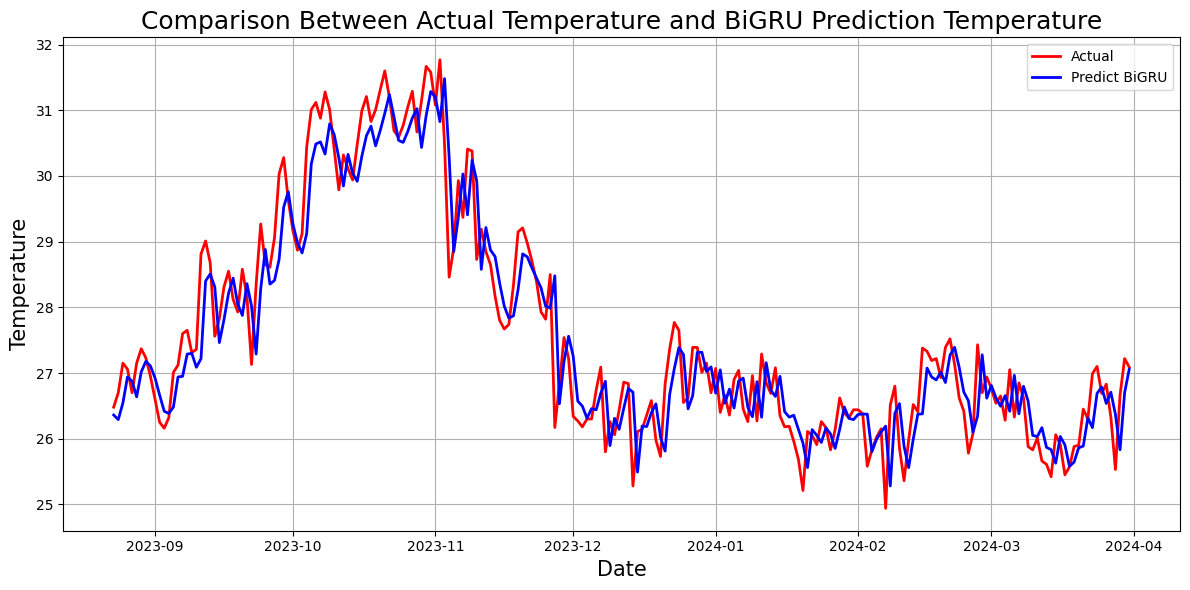

In [ ]:
# Plot data test BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiGRU'], label='Predict BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiGRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU.pdf', format='pdf')
plt.show()

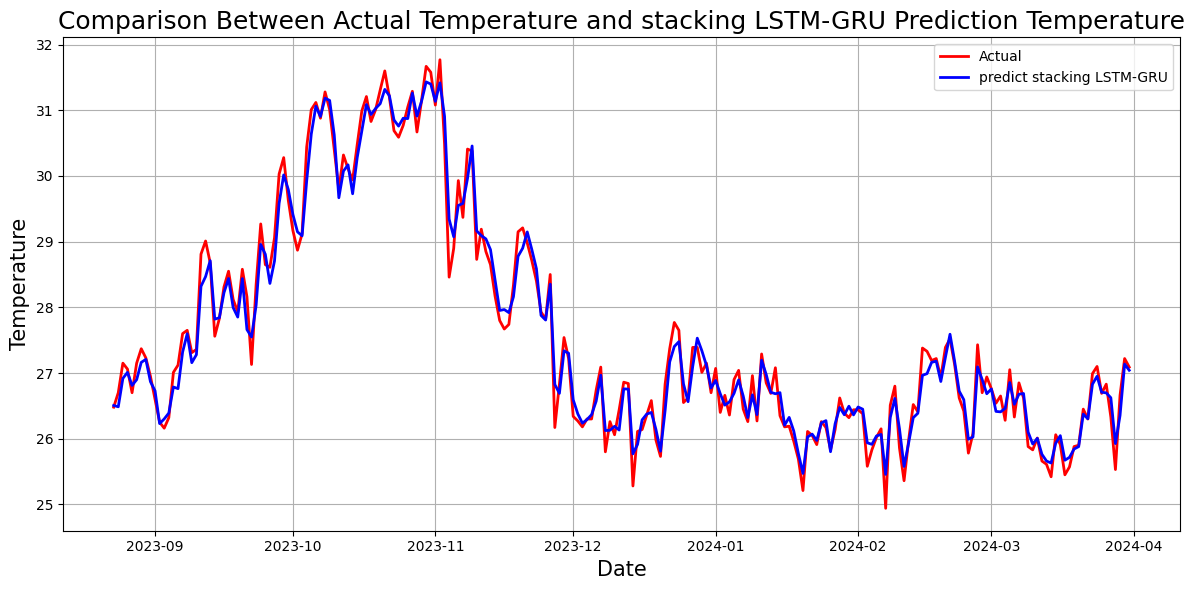

In [ ]:
# Plot data test LSTM-GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking LSTM-GRU'], label='predict stacking LSTM-GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking LSTM-GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking LSTM-GRU.pdf', format='pdf')
plt.show()

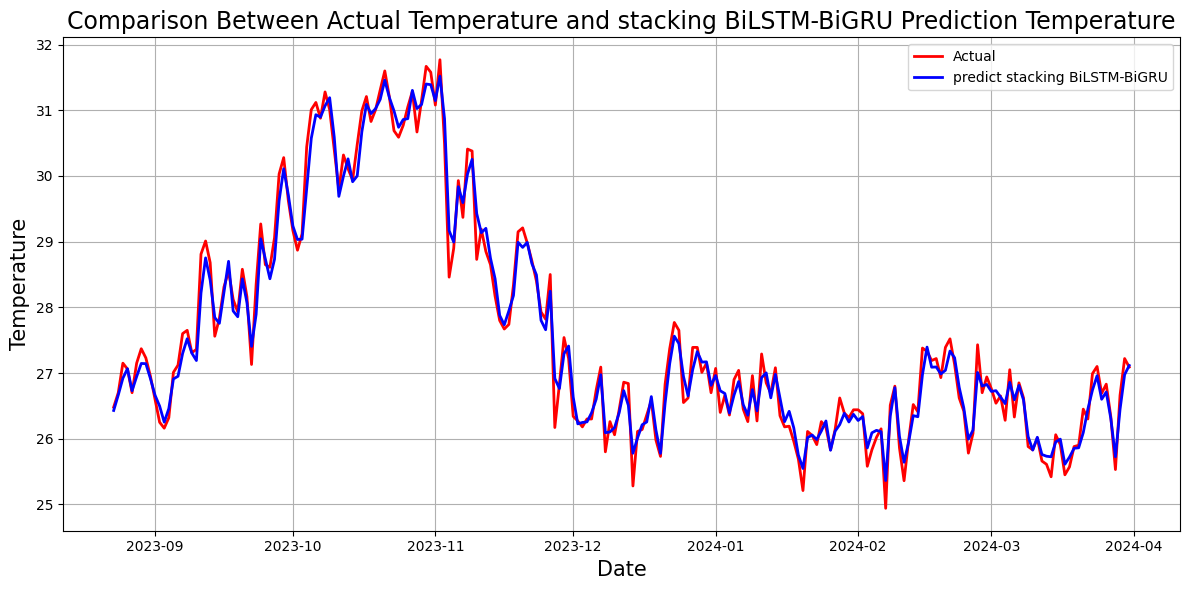

In [ ]:
# Plot data test BiLSTM-BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking BiLSTM-BiGRU'], label='predict stacking BiLSTM-BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking BiLSTM-BiGRU Prediction Temperature', fontsize=17)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking BiLSTM-BiGRU.pdf', format='pdf')
plt.show()

In [ ]:
excel_filename = 'real_predictions(7 hari).xlsx'
df_merge.to_excel(excel_filename, index=False)

In [ ]:
df_merge.set_index('date', inplace=True)

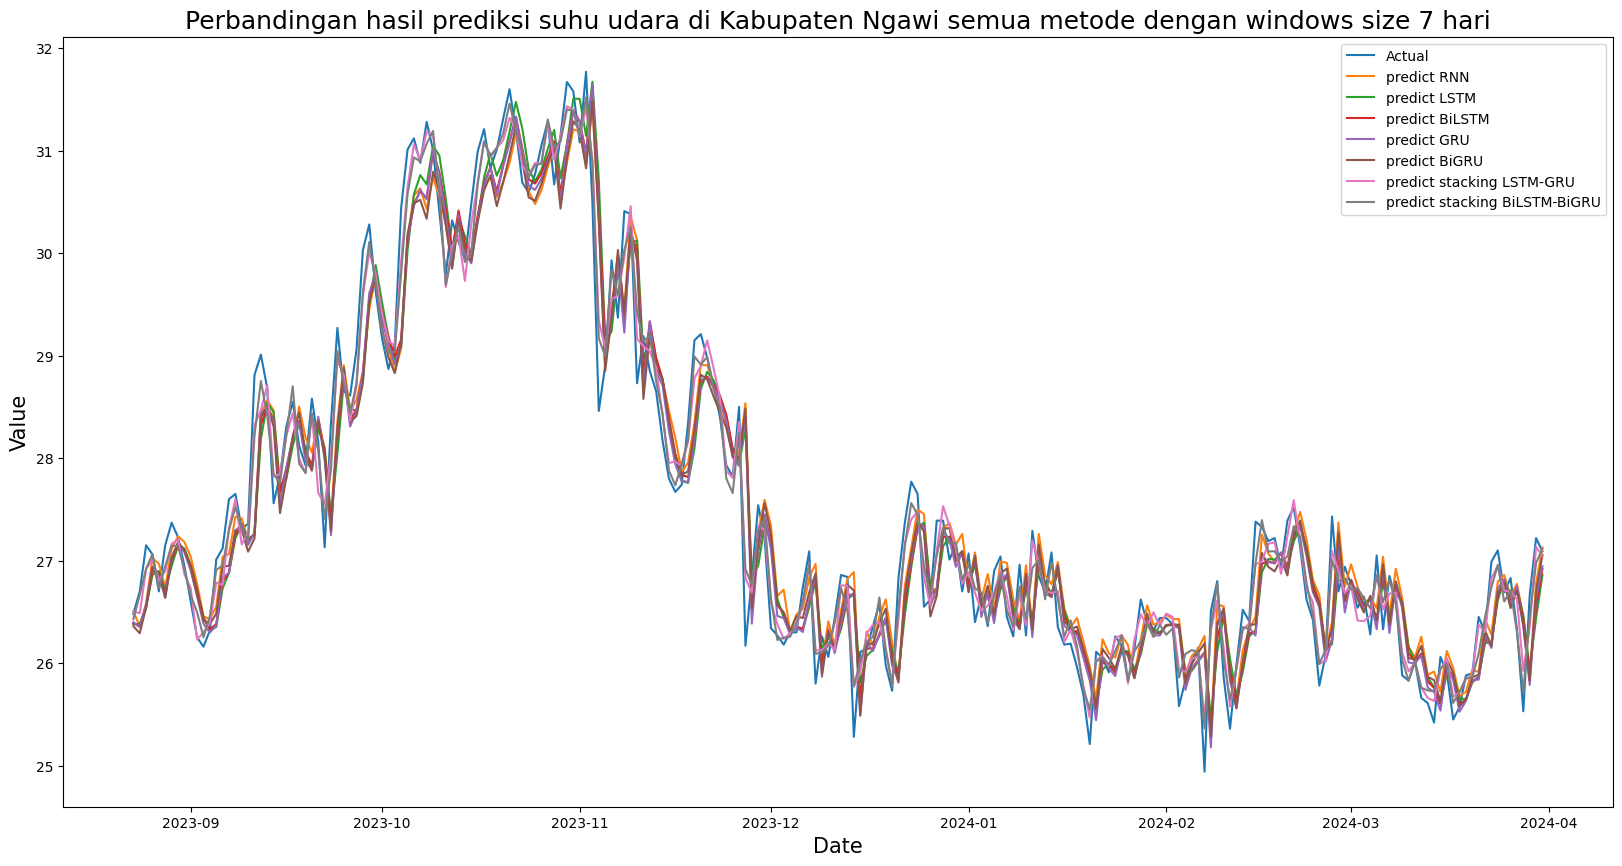

In [ ]:
# Membuat line plot dari semua kolom dengan keterangan
plt.figure(figsize=(20, 10))

for column in df_merge.columns:
    plt.plot(df_merge.index, df_merge[column], label=column)

# Menambahkan judul dan label sumbu
plt.title('Perbandingan hasil prediksi suhu udara di Kabupaten Ngawi semua metode dengan windows size 7 hari', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)

# Menampilkan legend
plt.legend(loc='best')

# Simpan plot ke PDF
plt.savefig('semua metode.pdf', format='pdf')
plt.show()

## Windows_size (15 hari)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.2860
Train RMSE: 0.5348
Train MAE: 0.4220
Train MAPE: 0.0162
Train R-squared: 0.8419
Test MSE: 0.3476
Test RMSE: 0.5896
Test MAE: 0.4562
Test MAPE: 0.0164
Test R-squared: 0.8836


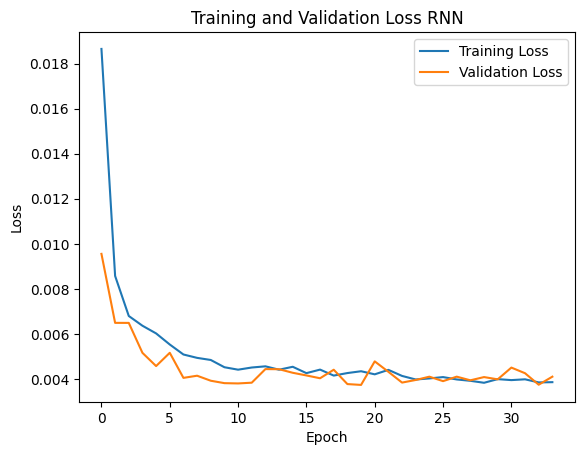

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.3046
Train RMSE: 0.5519
Train MAE: 0.4314
Train MAPE: 0.0166
Train R-squared: 0.8316
Test MSE: 0.3380
Test RMSE: 0.5814
Test MAE: 0.4497
Test MAPE: 0.0163
Test R-squared: 0.8868


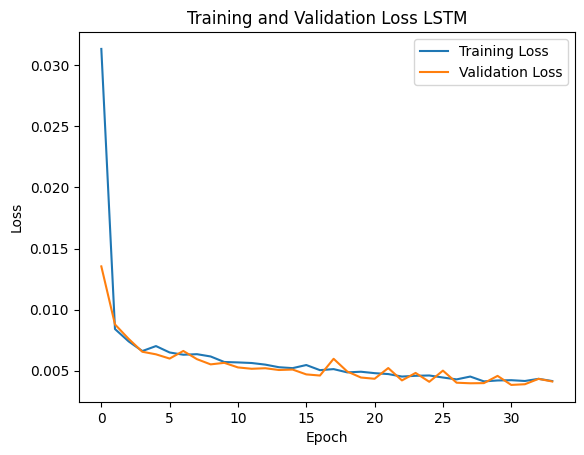

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.2795
Train RMSE: 0.5286
Train MAE: 0.4112
Train MAPE: 0.0158
Train R-squared: 0.8455
Test MSE: 0.3076
Test RMSE: 0.5547
Test MAE: 0.4301
Test MAPE: 0.0156
Test R-squared: 0.8970


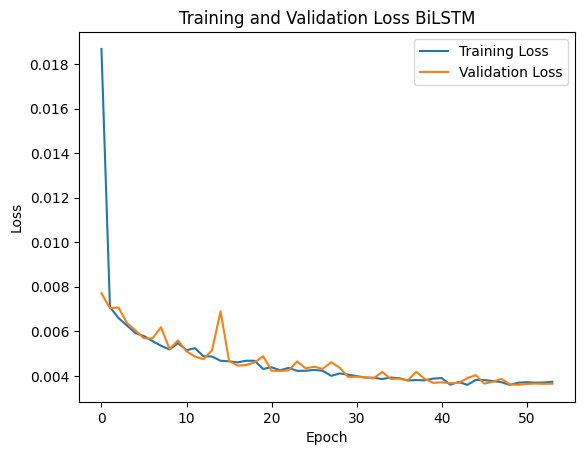

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 0.2933
Train RMSE: 0.5416
Train MAE: 0.4168
Train MAPE: 0.0161
Train R-squared: 0.8379
Test MSE: 0.3115
Test RMSE: 0.5582
Test MAE: 0.4324
Test MAPE: 0.0157
Test R-squared: 0.8957


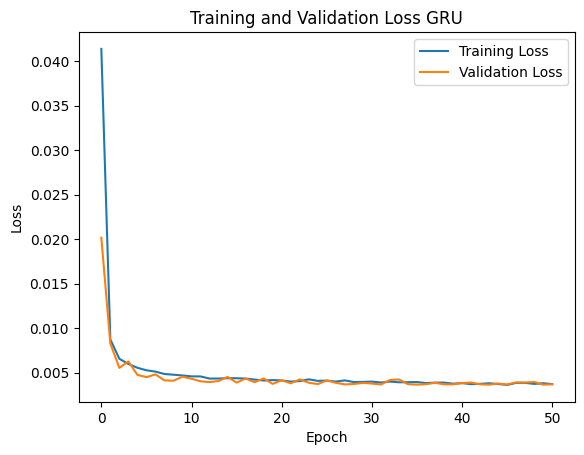

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 0.2846
Train RMSE: 0.5335
Train MAE: 0.4145
Train MAPE: 0.0160
Train R-squared: 0.8426
Test MSE: 0.3151
Test RMSE: 0.5614
Test MAE: 0.4342
Test MAPE: 0.0157
Test R-squared: 0.8945


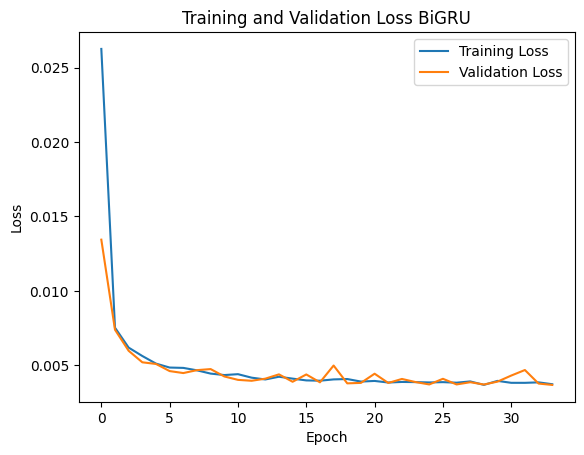

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi LSTM-GRU
Test MSE: 0.0583
Test RMSE: 0.2415
Test MAE: 0.1829
Test MAPE: 0.0066
Test R-squared: 0.9792


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi BiLSTM-BiGRU
Test MSE: 0.0538
Test RMSE: 0.2319
Test MAE: 0.1781
Test MAPE: 0.0065
Test R-squared: 0.9811


In [ ]:
feature_cols = ['T2M']
label_cols = ['T2M']

run_all(train, test, feature_cols, label_cols, 15, 50)

### Visualisasi Train

In [ ]:
df_rnn = pd.read_excel('/content/RNN_predictions.xlsx')
df_lstm = pd.read_excel('/content/LSTM_predictions.xlsx')
df_bilstm = pd.read_excel('/content/BiLSTM_predictions.xlsx')
df_gru = pd.read_excel('/content/GRU_predictions.xlsx')
df_bigru = pd.read_excel('/content/BiGRU_predictions.xlsx')
df_stack = pd.read_excel('/content/staking_predictions.xlsx')
df_stack2 = pd.read_excel('/content/staking_predictions2.xlsx')
train_rnn = pd.read_excel('/content/RNN_trainpredictions.xlsx')
train_lstm = pd.read_excel('/content/LSTM_trainpredictions.xlsx')
train_bilstm = pd.read_excel('/content/BiLSTM_trainpredictions.xlsx')
train_gru = pd.read_excel('/content/GRU_trainpredictions.xlsx')
train_bigru = pd.read_excel('/content/BiGRU_trainpredictions.xlsx')

In [ ]:
date_range = pd.date_range(start='2018-01-16', periods=len(train_lstm), freq='D')
train_rnn['date'] = date_range
train_lstm['date'] = date_range
train_bilstm['date'] = date_range
train_gru['date'] = date_range
train_bigru['date'] = date_range

In [ ]:
df_train = pd.merge(train_rnn, train_lstm)
df_train = pd.merge(df_train, train_bilstm)
df_train = pd.merge(df_train, train_gru)
df_train = pd.merge(df_train, train_bigru)
df_train['date']
df_train.head()

Actual Training  Predicted Training RNN       date  \
0        24.570000               24.965132 2018-01-16   
1        25.700001               24.750580 2018-01-17   
2        25.330000               25.487968 2018-01-18   
3        25.150000               25.185684 2018-01-19   
4        24.879999               25.150600 2018-01-20   

   Predicted Training LSTM  Predicted Training BiLSTM  Predicted Training GRU  \
0                25.036812                  25.053970               25.138798   
1                24.891006                  24.868591               24.901419   
2                25.287682                  25.549051               25.720730   
3                25.301422                  25.356255               25.378288   
4                25.231932                  25.227312               25.320803   

   Predicted Training BiGRU  
0                 25.112083  
1                 24.907122  
2                 25.672461  
3                 25.396849  
4                 25.296377

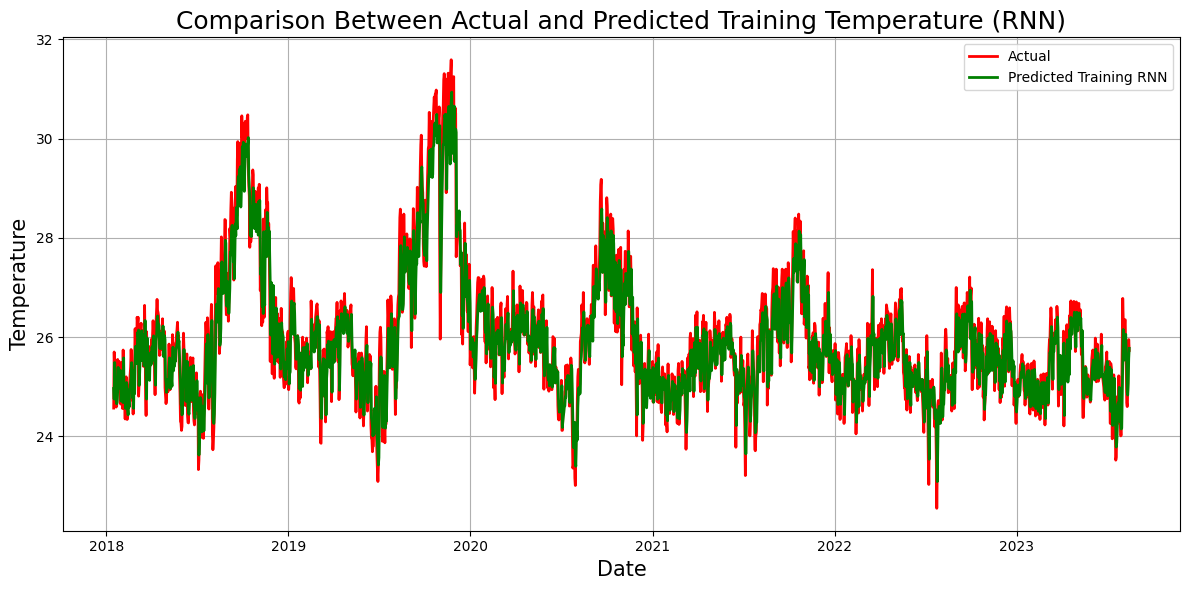

In [ ]:
# Plot data train RNN
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training RNN'], label='Predicted Training RNN', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (RNN)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN train.pdf', format='pdf')
plt.show()

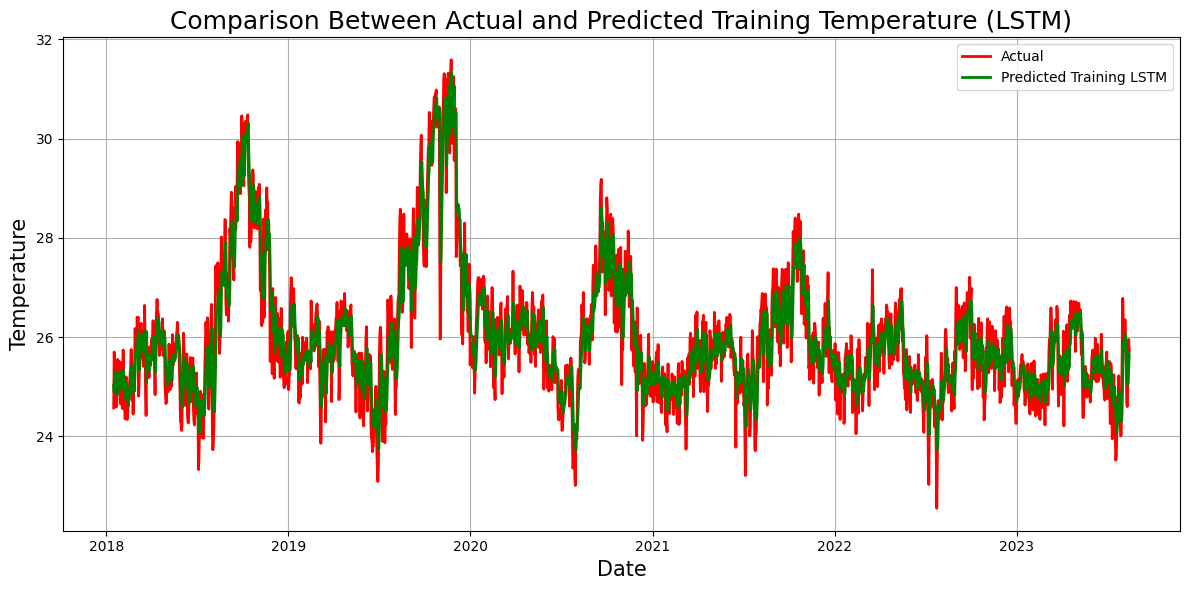

In [ ]:
# Plot data train LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training LSTM'], label='Predicted Training LSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (LSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM train.pdf', format='pdf')
plt.show()

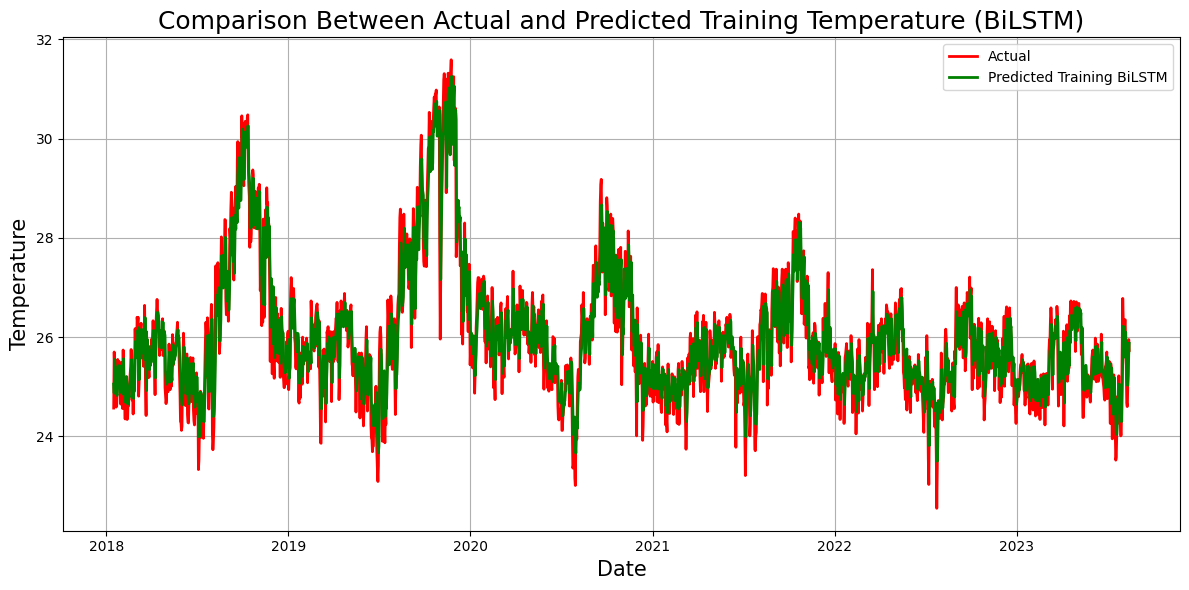

In [ ]:
# Plot data train BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiLSTM'], label='Predicted Training BiLSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiLSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM train.pdf', format='pdf')
plt.show()

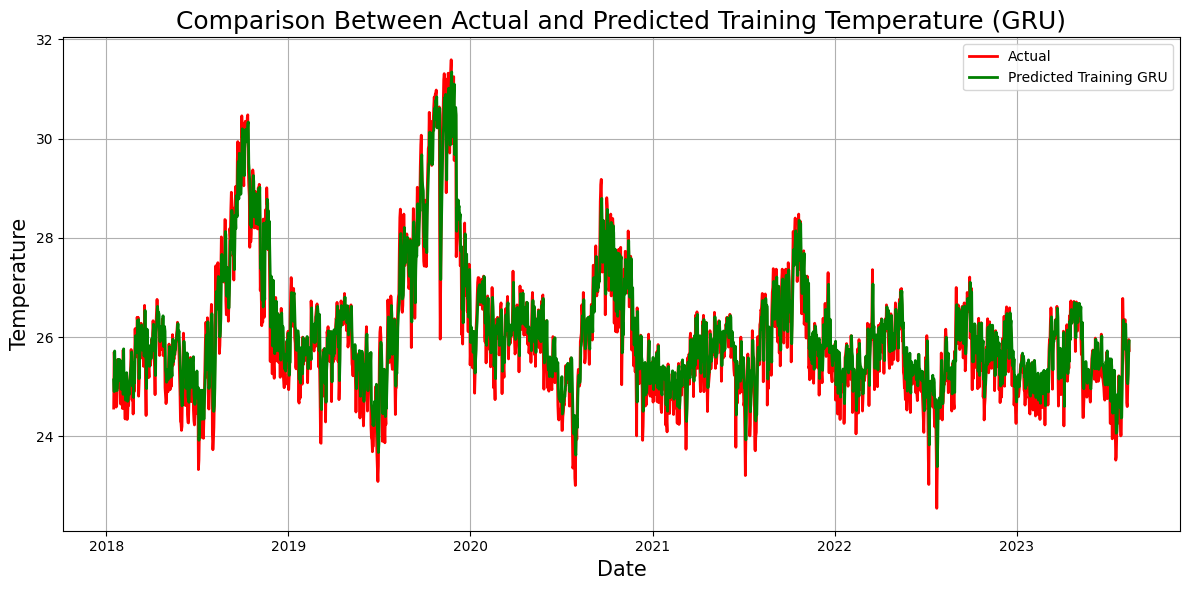

In [ ]:
# Plot data train GRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training GRU'], label='Predicted Training GRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (GRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU train.pdf', format='pdf')
plt.show()

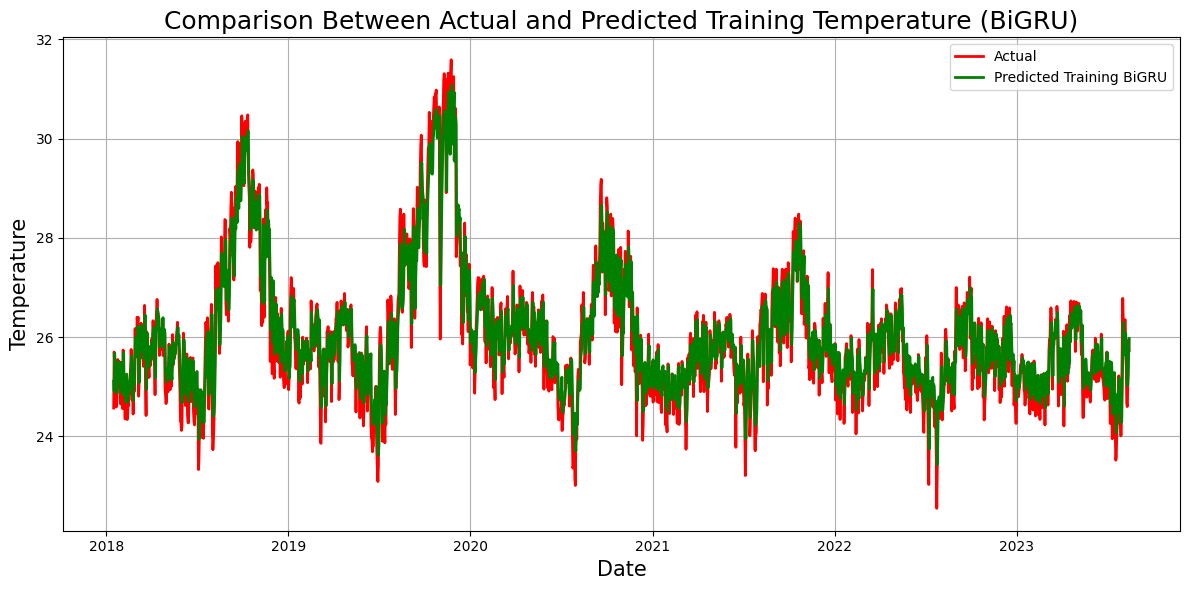

In [ ]:
# Plot data train BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiGRU'], label='Predicted Training BiGRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiGRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU train.pdf', format='pdf')
plt.show()

### Visualisasi prediksi


In [ ]:
date_range = pd.date_range(start='2023-08-31', periods=len(df_lstm), freq='D')
df_rnn['date'] = date_range
df_lstm['date'] = date_range
df_bilstm['date'] = date_range
df_gru['date'] = date_range
df_bigru['date'] = date_range
df_stack['date'] = date_range
df_stack2['date'] = date_range

In [ ]:
df_merge = pd.merge(df_rnn, df_lstm)
df_merge = pd.merge(df_merge, df_bilstm)
df_merge = pd.merge(df_merge, df_gru)
df_merge = pd.merge(df_merge, df_bigru)
df_merge = pd.merge(df_merge, df_stack)
df_merge = pd.merge(df_merge, df_stack2)
df_merge['date']
df_merge.head()

Actual  Predicted RNN       date  Predicted LSTM  Predicted BiLSTM  \
0  26.950001      26.975414 2023-08-31       27.014776         27.039570   
1  26.600000      26.782221 2023-09-01       26.900009         26.873344   
2  26.250000      26.567755 2023-09-02       26.704418         26.646969   
3  26.160002      26.312057 2023-09-03       26.475748         26.411438   
4  26.320000      26.222462 2023-09-04       26.350147         26.352200   

   Predicted GRU  Predicted BiGRU  predict stacking LSTM-GRU  \
0      27.145006        27.041916                  26.892801   
1      26.973606        26.885841                  26.872500   
2      26.741890        26.657564                  26.340800   
3      26.496613        26.417231                  26.295800   
4      26.427057        26.365084                  26.249700   

   predict stacking BiLSTM-BiGRU  
0                      26.942701  
1                      26.701001  
2                      26.286500  
3                      26.205601  
4                      26.568400

In [ ]:
df_merge = df_merge[['date', 'Actual','Predicted RNN', 'Predicted LSTM', 'Predicted BiLSTM', 'Predicted GRU', 'Predicted BiGRU', 'predict stacking LSTM-GRU','predict stacking BiLSTM-BiGRU']]
df_merge = df_merge.rename(columns={'Predicted RNN':'predict RNN', 'Predicted LSTM' : 'predict LSTM', 'Predicted BiLSTM' : 'predict BiLSTM', 'Predicted GRU' : 'predict GRU', 'Predicted BiGRU' : 'predict BiGRU'})

df_merge.head()

date     Actual  predict RNN  predict LSTM  predict BiLSTM  \
0 2023-08-31  26.950001    26.975414     27.014776       27.039570   
1 2023-09-01  26.600000    26.782221     26.900009       26.873344   
2 2023-09-02  26.250000    26.567755     26.704418       26.646969   
3 2023-09-03  26.160002    26.312057     26.475748       26.411438   
4 2023-09-04  26.320000    26.222462     26.350147       26.352200   

   predict GRU  predict BiGRU  predict stacking LSTM-GRU  \
0    27.145006      27.041916                  26.892801   
1    26.973606      26.885841                  26.872500   
2    26.741890      26.657564                  26.340800   
3    26.496613      26.417231                  26.295800   
4    26.427057      26.365084                  26.249700   

   predict stacking BiLSTM-BiGRU  
0                      26.942701  
1                      26.701001  
2                      26.286500  
3                      26.205601  
4                      26.568400

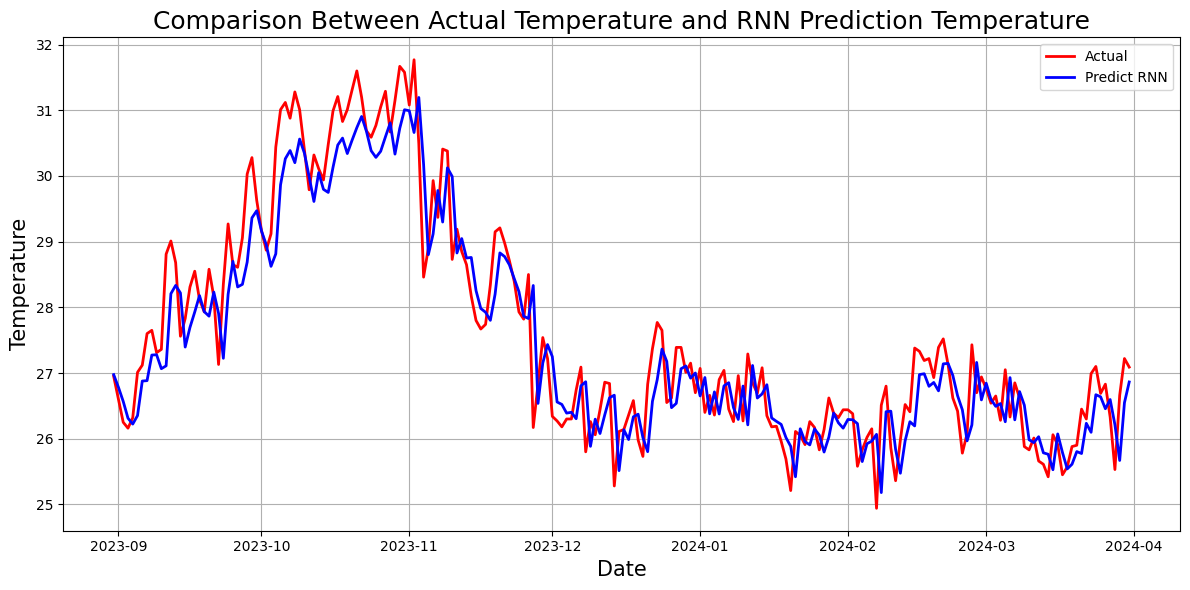

In [ ]:
# Plot data test RNN
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict RNN'], label='Predict RNN', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and RNN Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN.pdf', format='pdf')
plt.show()

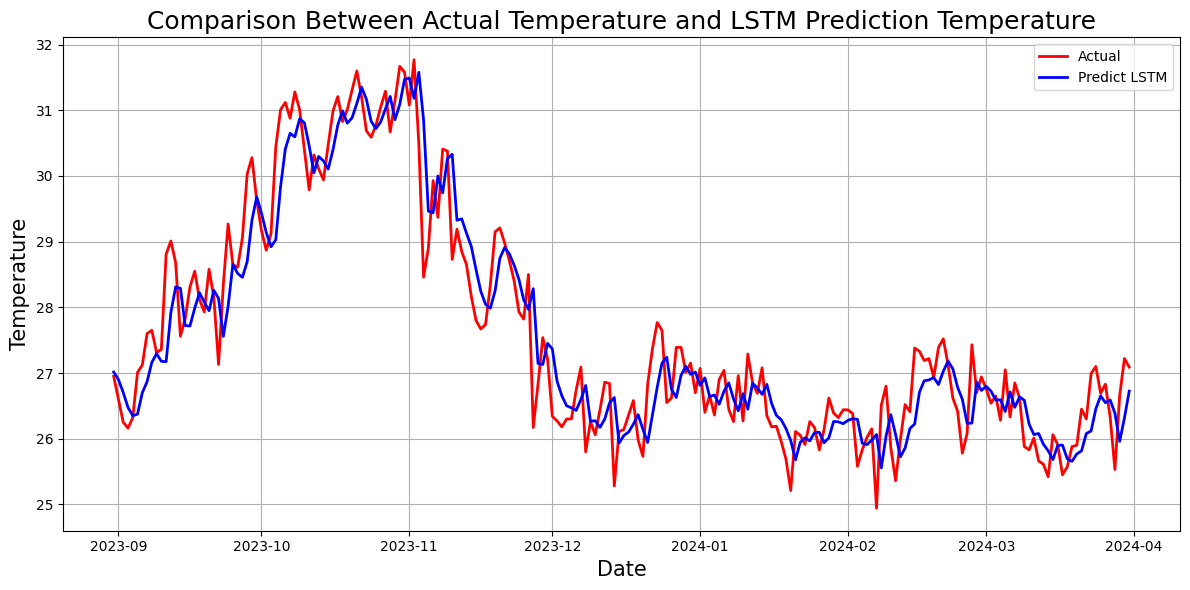

In [ ]:
# Plot data test LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict LSTM'], label='Predict LSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and LSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM.pdf', format='pdf')
plt.show()

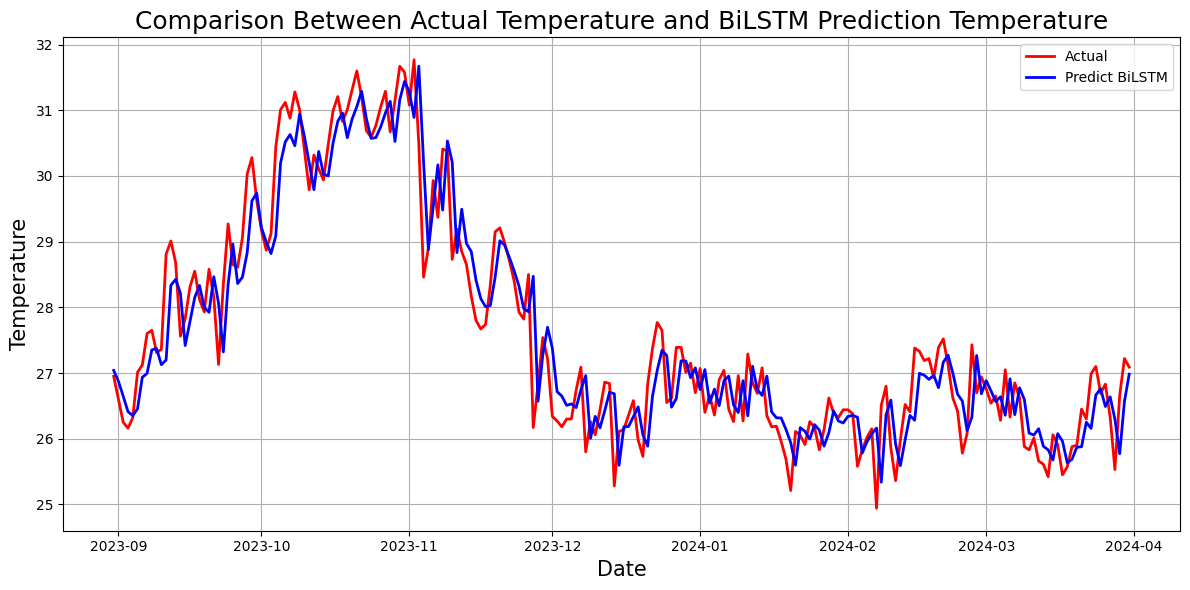

In [ ]:
# Plot data test BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiLSTM'], label='Predict BiLSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiLSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM.pdf', format='pdf')
plt.show()

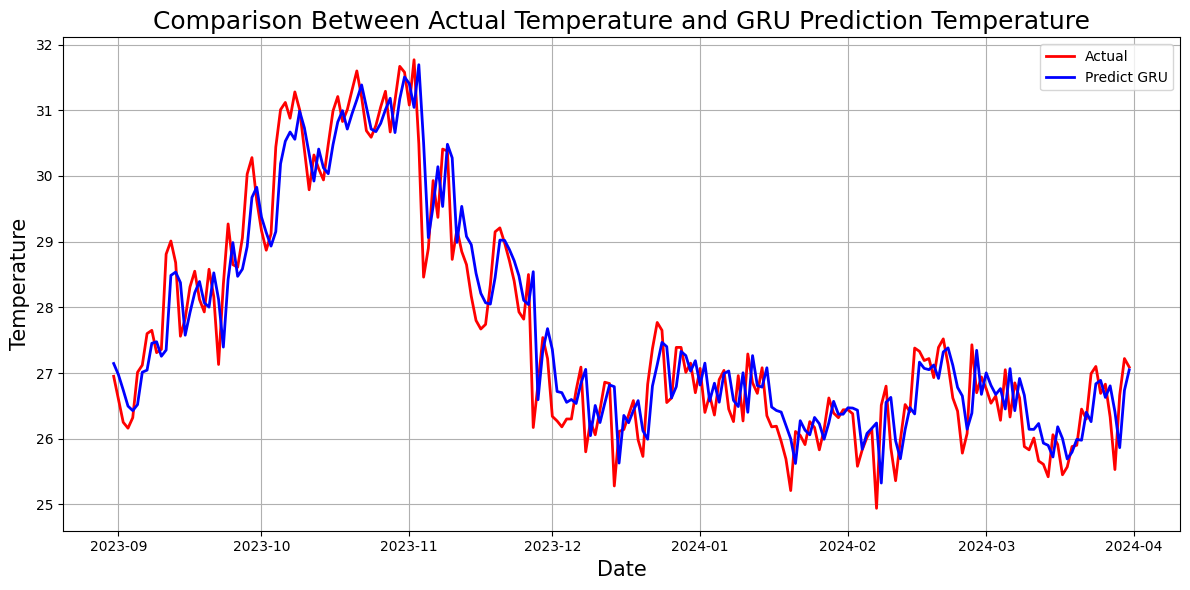

In [ ]:
# Plot data test GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict GRU'], label='Predict GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU.pdf', format='pdf')
plt.show()

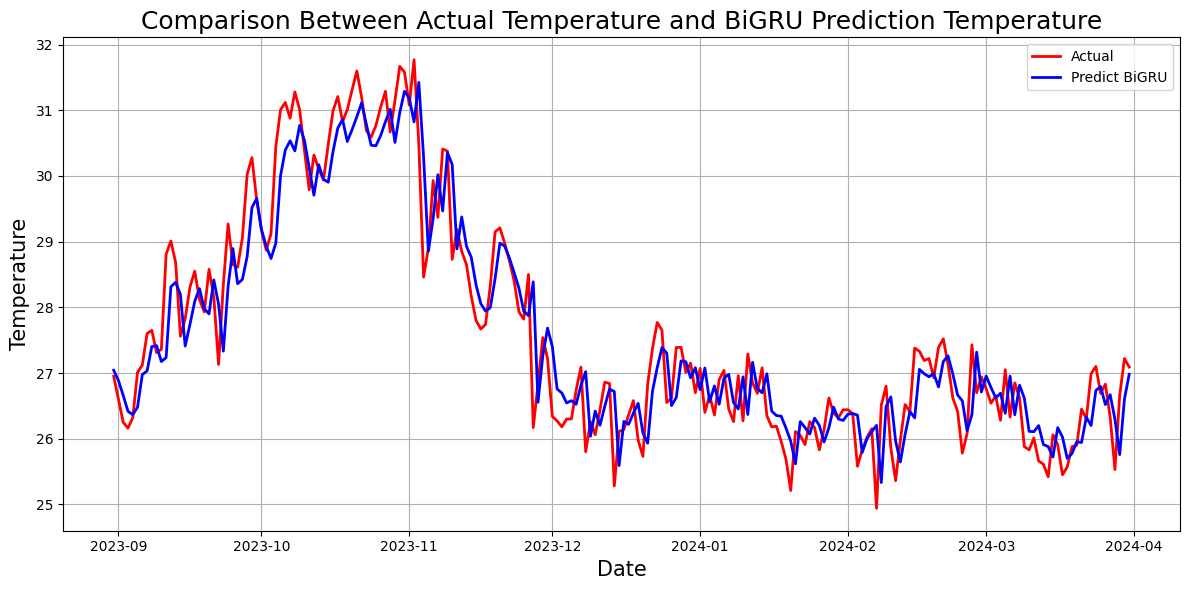

In [ ]:
# Plot data test BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiGRU'], label='Predict BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiGRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU.pdf', format='pdf')
plt.show()

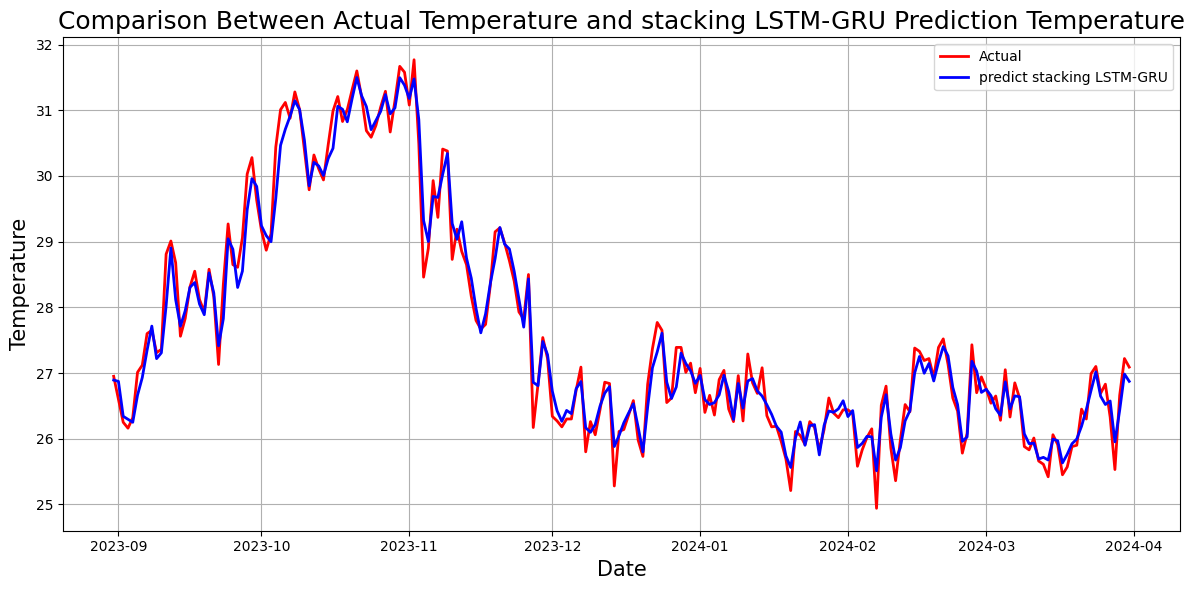

In [ ]:
# Plot data test LSTM-GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking LSTM-GRU'], label='predict stacking LSTM-GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking LSTM-GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking LSTM-GRU.pdf', format='pdf')
plt.show()

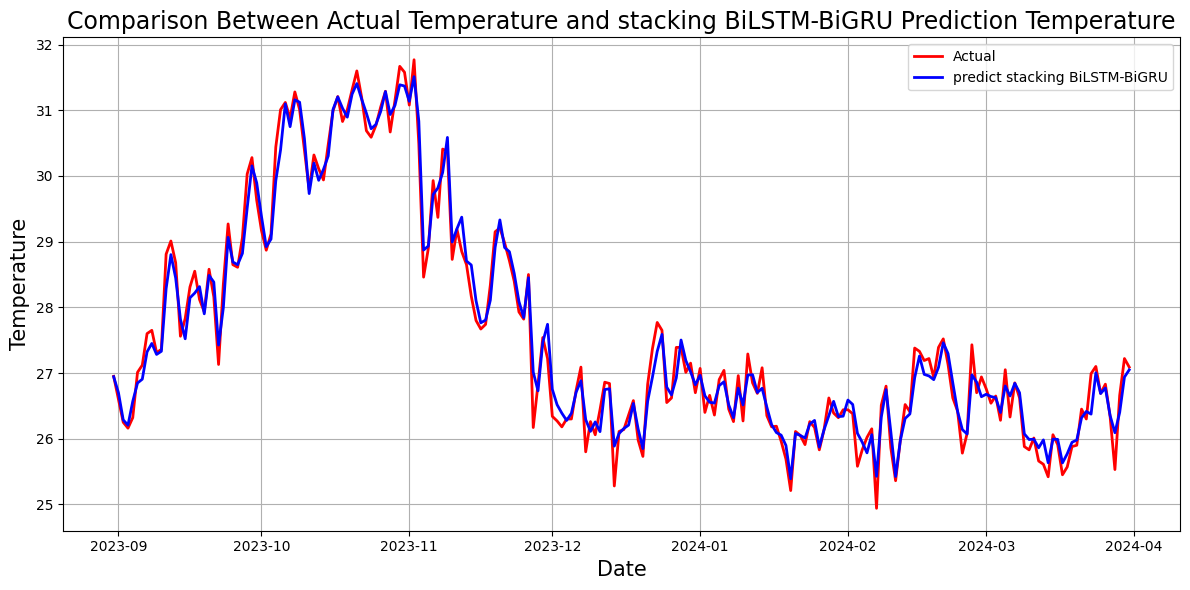

In [ ]:
# Plot data test BiLSTM-BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking BiLSTM-BiGRU'], label='predict stacking BiLSTM-BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking BiLSTM-BiGRU Prediction Temperature', fontsize=17)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking BiLSTM-BiGRU.pdf', format='pdf')
plt.show()

In [ ]:
excel_filename = 'real_predictions(15 hari).xlsx'
df_merge.to_excel(excel_filename, index=False)

In [ ]:
df_merge.set_index('date', inplace=True)

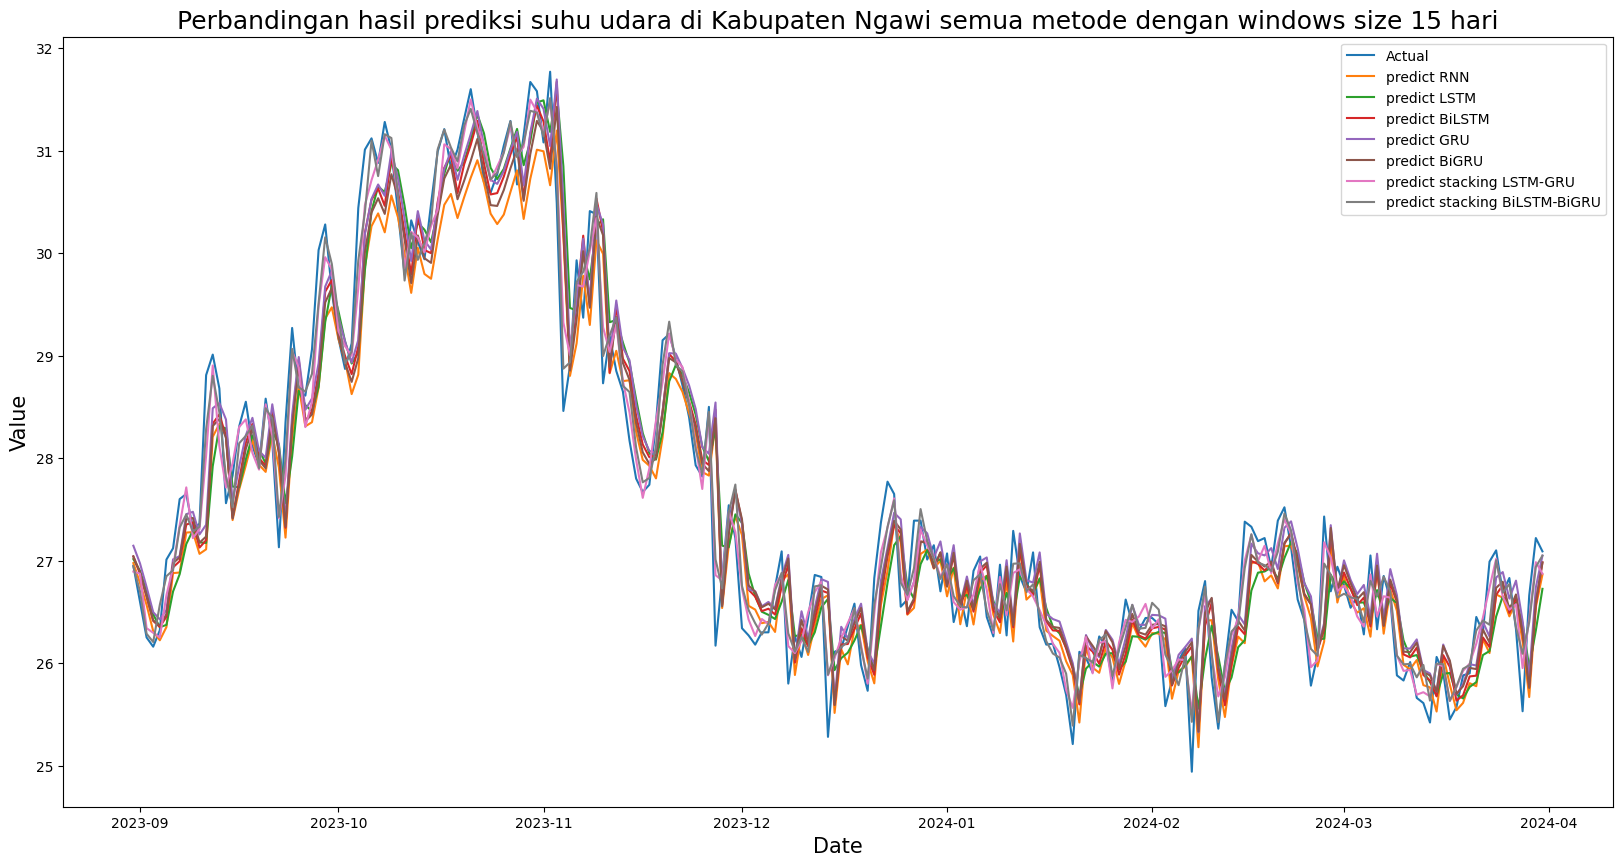

In [ ]:
# Membuat line plot dari semua kolom dengan keterangan
plt.figure(figsize=(20, 10))

for column in df_merge.columns:
    plt.plot(df_merge.index, df_merge[column], label=column)

# Menambahkan judul dan label sumbu
plt.title('Perbandingan hasil prediksi suhu udara di Kabupaten Ngawi semua metode dengan windows size 15 hari', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)

# Menampilkan legend
plt.legend(loc='best')

# Simpan plot ke PDF
plt.savefig('semua metode.pdf', format='pdf')
plt.show()

## Windows_size (30 hari)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.2860
Train RMSE: 0.5348
Train MAE: 0.4120
Train MAPE: 0.0159
Train R-squared: 0.8424
Test MSE: 0.3213
Test RMSE: 0.5668
Test MAE: 0.4369
Test MAPE: 0.0159
Test R-squared: 0.8980


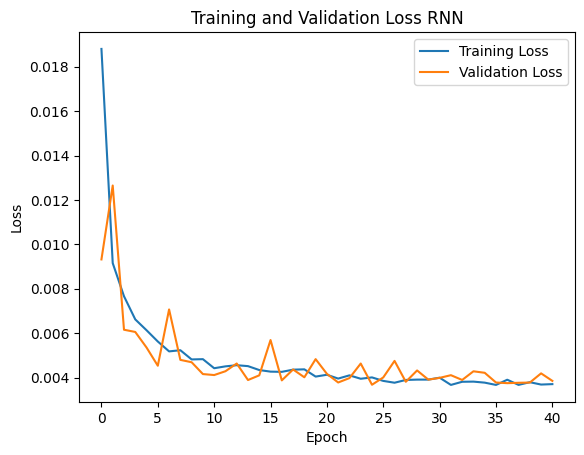

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train MSE: 0.2899
Train RMSE: 0.5384
Train MAE: 0.4209
Train MAPE: 0.0162
Train R-squared: 0.8403
Test MSE: 0.3175
Test RMSE: 0.5635
Test MAE: 0.4342
Test MAPE: 0.0157
Test R-squared: 0.8992


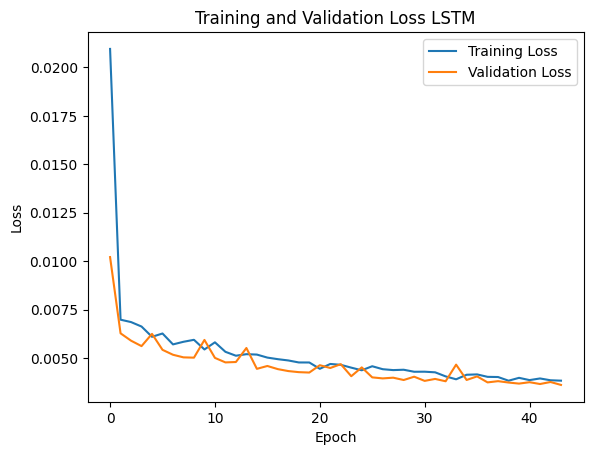

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train MSE: 0.2834
Train RMSE: 0.5324
Train MAE: 0.4172
Train MAPE: 0.0160
Train R-squared: 0.8439
Test MSE: 0.3193
Test RMSE: 0.5651
Test MAE: 0.4370
Test MAPE: 0.0158
Test R-squared: 0.8986


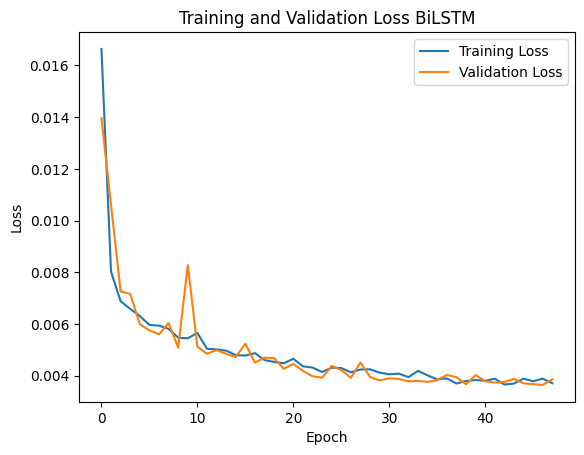

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 0.3265
Train RMSE: 0.5714
Train MAE: 0.4387
Train MAPE: 0.0170
Train R-squared: 0.8201
Test MSE: 0.3405
Test RMSE: 0.5835
Test MAE: 0.4503
Test MAPE: 0.0164
Test R-squared: 0.8919


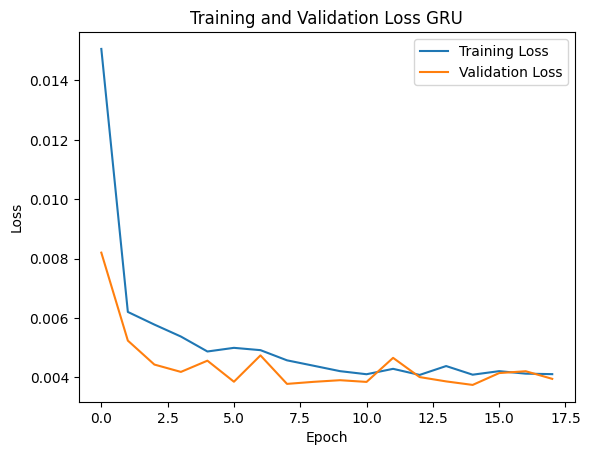

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 0.2822
Train RMSE: 0.5313
Train MAE: 0.4125
Train MAPE: 0.0159
Train R-squared: 0.8445
Test MSE: 0.3264
Test RMSE: 0.5713
Test MAE: 0.4389
Test MAPE: 0.0159
Test R-squared: 0.8964


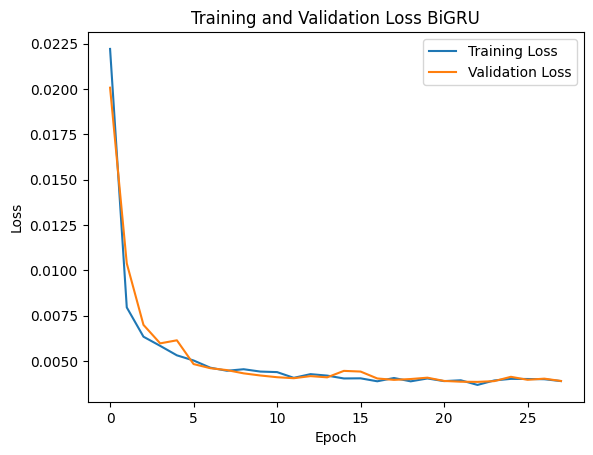

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi LSTM-GRU
Test MSE: 0.0565
Test RMSE: 0.2376
Test MAE: 0.1865
Test MAPE: 0.0067
Test R-squared: 0.9810


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Metriks Evaluasi BiLSTM-BiGRU
Test MSE: 0.0554
Test RMSE: 0.2353
Test MAE: 0.1808
Test MAPE: 0.0065
Test R-squared: 0.9816


In [ ]:
feature_cols = ['T2M']
label_cols = ['T2M']

run_all(train, test, feature_cols, label_cols, 30, 50)

### Visualisasi Train

In [ ]:
df_rnn = pd.read_excel('/content/RNN_predictions.xlsx')
df_lstm = pd.read_excel('/content/LSTM_predictions.xlsx')
df_bilstm = pd.read_excel('/content/BiLSTM_predictions.xlsx')
df_gru = pd.read_excel('/content/GRU_predictions.xlsx')
df_bigru = pd.read_excel('/content/BiGRU_predictions.xlsx')
df_stack = pd.read_excel('/content/staking_predictions.xlsx')
df_stack2 = pd.read_excel('/content/staking_predictions2.xlsx')
train_rnn = pd.read_excel('/content/RNN_trainpredictions.xlsx')
train_lstm = pd.read_excel('/content/LSTM_trainpredictions.xlsx')
train_bilstm = pd.read_excel('/content/BiLSTM_trainpredictions.xlsx')
train_gru = pd.read_excel('/content/GRU_trainpredictions.xlsx')
train_bigru = pd.read_excel('/content/BiGRU_trainpredictions.xlsx')

In [ ]:
date_range = pd.date_range(start='2018-01-31', periods=len(train_lstm), freq='D')
train_rnn['date'] = date_range
train_lstm['date'] = date_range
train_bilstm['date'] = date_range
train_gru['date'] = date_range
train_bigru['date'] = date_range

In [ ]:
df_train = pd.merge(train_rnn, train_lstm)
df_train = pd.merge(df_train, train_bilstm)
df_train = pd.merge(df_train, train_gru)
df_train = pd.merge(df_train, train_bigru)
df_train['date']
df_train.head()

Actual Training  Predicted Training RNN       date  \
0        24.930000               24.820683 2018-01-31   
1        25.170000               25.138014 2018-02-01   
2        25.490000               25.236012 2018-02-02   
3        24.559999               25.404125 2018-02-03   
4        25.740000               24.791433 2018-02-04   

   Predicted Training LSTM  Predicted Training BiLSTM  Predicted Training GRU  \
0                24.943233                  24.929773               25.084246   
1                25.015934                  25.055149               25.199181   
2                25.156425                  25.182932               25.358158   
3                25.365795                  25.408728               25.580999   
4                24.931671                  24.893652               25.046856   

   Predicted Training BiGRU  
0                 24.887091  
1                 25.087509  
2                 25.184278  
3                 25.429379  
4                 24.801634

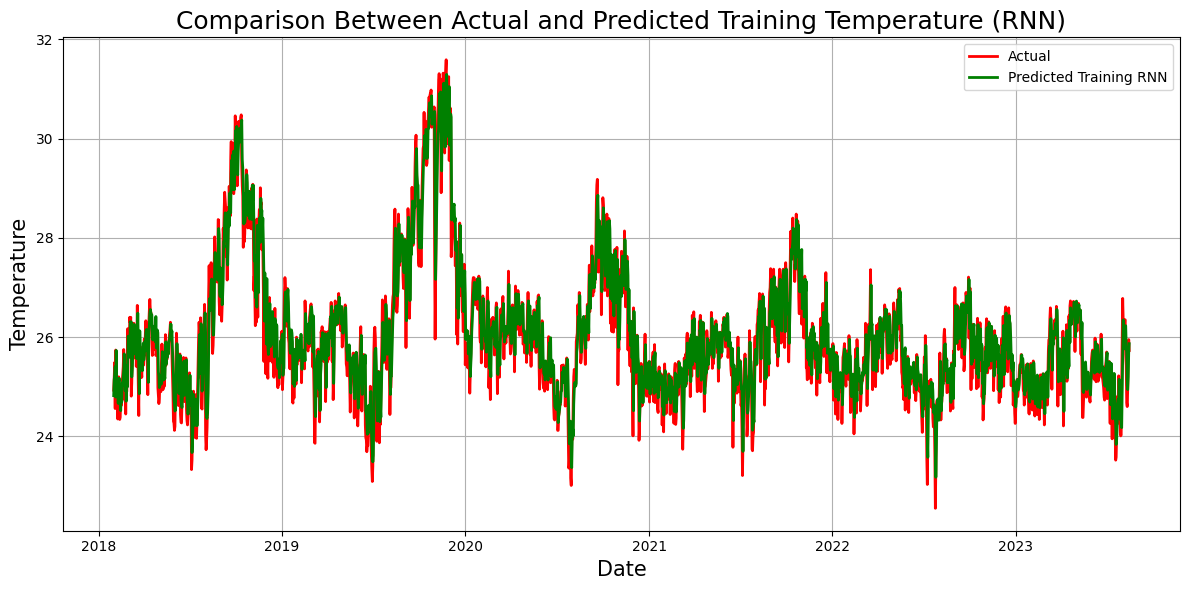

In [ ]:
# Plot data train RNN
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training RNN'], label='Predicted Training RNN', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (RNN)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN train.pdf', format='pdf')
plt.show()

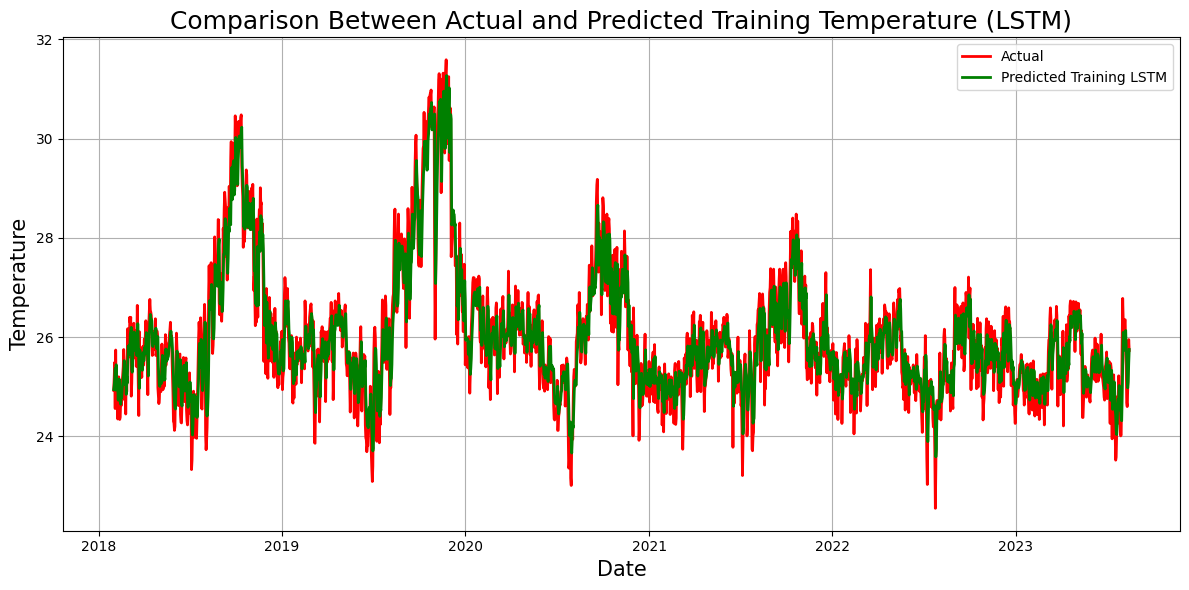

In [ ]:
# Plot data train LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training LSTM'], label='Predicted Training LSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (LSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM train.pdf', format='pdf')
plt.show()

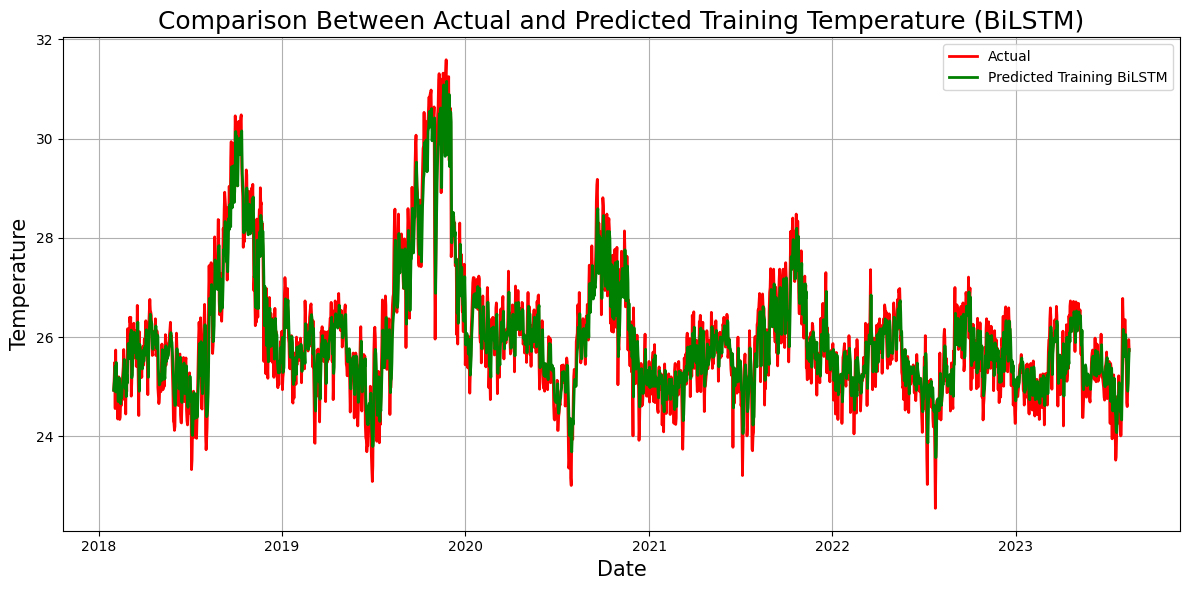

In [ ]:
# Plot data train BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiLSTM'], label='Predicted Training BiLSTM', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiLSTM)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM train.pdf', format='pdf')
plt.show()

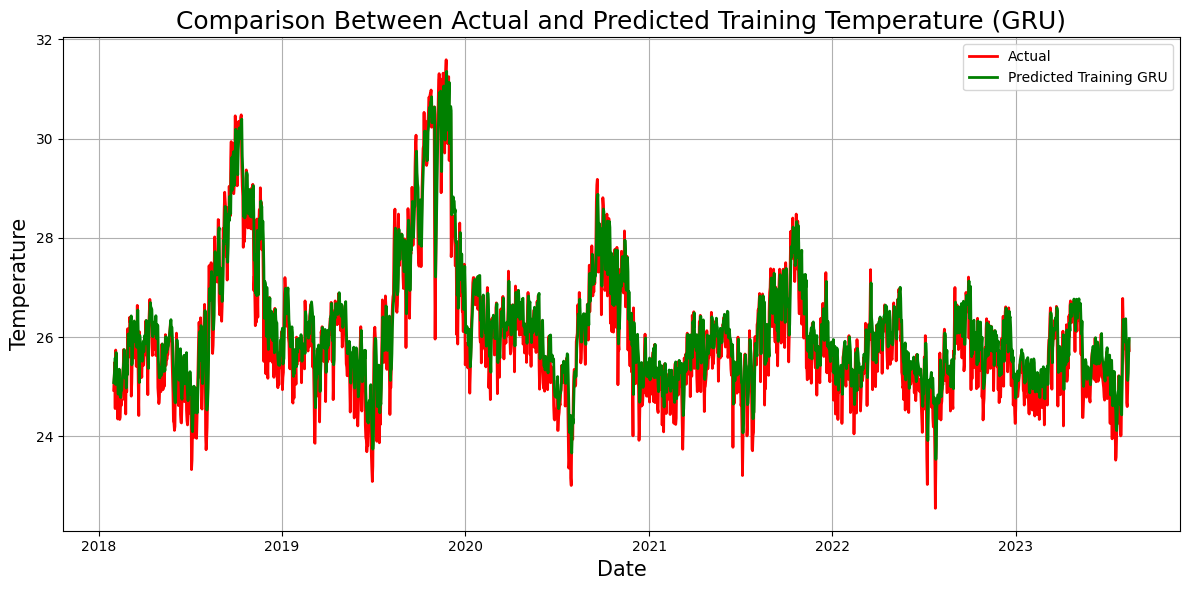

In [ ]:
# Plot data train GRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training GRU'], label='Predicted Training GRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (GRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU train.pdf', format='pdf')
plt.show()

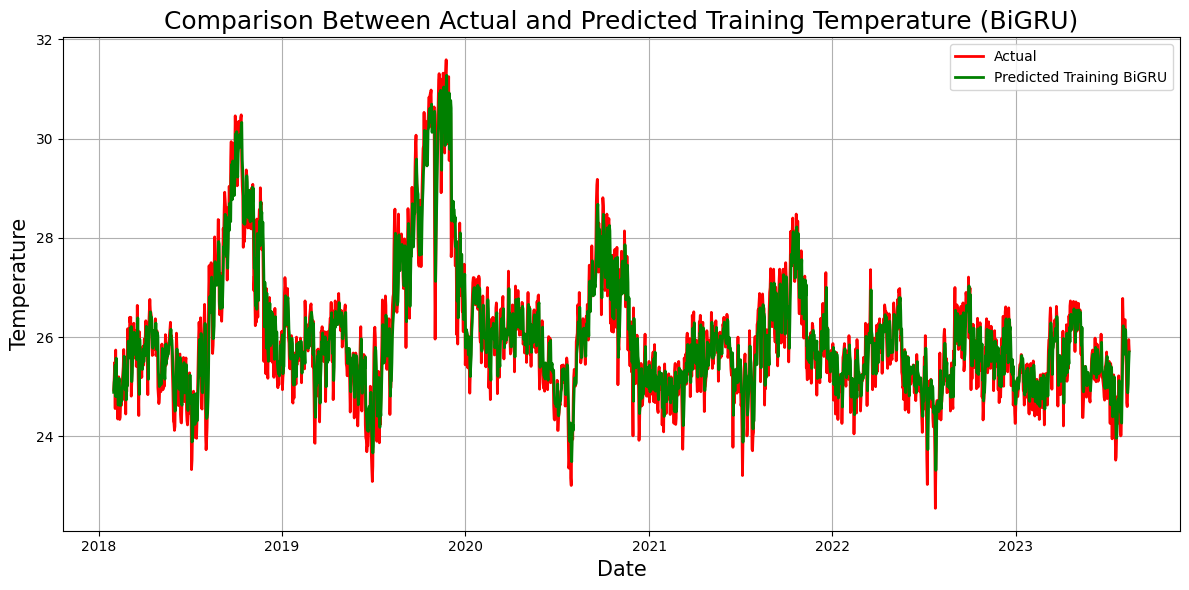

In [ ]:
# Plot data train BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_train['date'], df_train['Actual Training'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_train['date'], df_train['Predicted Training BiGRU'], label='Predicted Training BiGRU', color='green', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual and Predicted Training Temperature (BiGRU)', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU train.pdf', format='pdf')
plt.show()

### Visualisasi prediksi


In [ ]:
date_range = pd.date_range(start='2023-09-15', periods=len(df_lstm), freq='D')
df_rnn['date'] = date_range
df_lstm['date'] = date_range
df_bilstm['date'] = date_range
df_gru['date'] = date_range
df_bigru['date'] = date_range
df_stack['date'] = date_range
df_stack2['date'] = date_range

In [ ]:
df_merge = pd.merge(df_rnn, df_lstm)
df_merge = pd.merge(df_merge, df_bilstm)
df_merge = pd.merge(df_merge, df_gru)
df_merge = pd.merge(df_merge, df_bigru)
df_merge = pd.merge(df_merge, df_stack)
df_merge = pd.merge(df_merge, df_stack2)
df_merge['date']
df_merge.head()

Actual  Predicted RNN       date  Predicted LSTM  Predicted BiLSTM  \
0  27.830000      27.678278 2023-09-15       27.571693         27.423756   
1  28.309999      27.945957 2023-09-16       27.681591         27.683552   
2  28.549999      28.236677 2023-09-17       28.019451         28.093470   
3  28.120001      28.510374 2023-09-18       28.237614         28.299742   
4  27.930000      28.220894 2023-09-19       27.993208         27.994522   

   Predicted GRU  Predicted BiGRU  predict stacking LSTM-GRU  \
0      27.773441        27.547396                  27.812200   
1      27.934093        27.855804                  28.228000   
2      28.278759        28.179905                  28.197500   
3      28.475878        28.324526                  28.182801   
4      28.206858        28.018934                  27.910700   

   predict stacking BiLSTM-BiGRU  
0                      27.667000  
1                      28.135100  
2                      28.349200  
3                      28.362701  
4                      27.891700

In [ ]:
df_merge = df_merge[['date', 'Actual','Predicted RNN', 'Predicted LSTM', 'Predicted BiLSTM', 'Predicted GRU', 'Predicted BiGRU', 'predict stacking LSTM-GRU','predict stacking BiLSTM-BiGRU']]
df_merge = df_merge.rename(columns={'Predicted RNN':'predict RNN', 'Predicted LSTM' : 'predict LSTM', 'Predicted BiLSTM' : 'predict BiLSTM', 'Predicted GRU' : 'predict GRU', 'Predicted BiGRU' : 'predict BiGRU'})

df_merge.head()

date     Actual  predict RNN  predict LSTM  predict BiLSTM  \
0 2023-09-15  27.830000    27.678278     27.571693       27.423756   
1 2023-09-16  28.309999    27.945957     27.681591       27.683552   
2 2023-09-17  28.549999    28.236677     28.019451       28.093470   
3 2023-09-18  28.120001    28.510374     28.237614       28.299742   
4 2023-09-19  27.930000    28.220894     27.993208       27.994522   

   predict GRU  predict BiGRU  predict stacking LSTM-GRU  \
0    27.773441      27.547396                  27.812200   
1    27.934093      27.855804                  28.228000   
2    28.278759      28.179905                  28.197500   
3    28.475878      28.324526                  28.182801   
4    28.206858      28.018934                  27.910700   

   predict stacking BiLSTM-BiGRU  
0                      27.667000  
1                      28.135100  
2                      28.349200  
3                      28.362701  
4                      27.891700

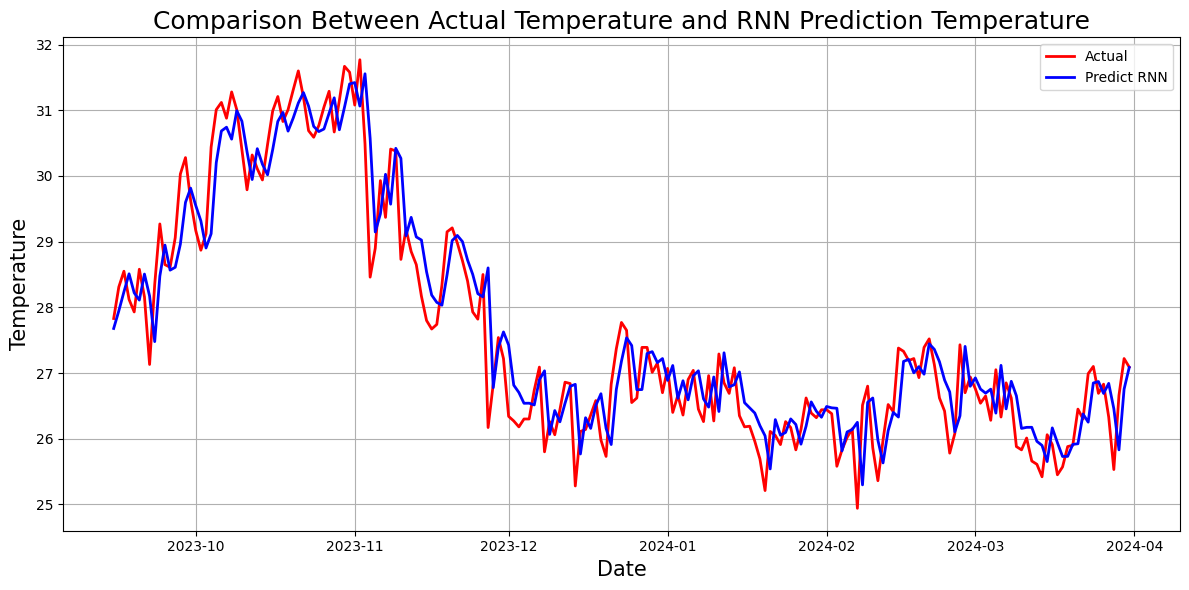

In [ ]:
# Plot data test RNN
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict RNN'], label='Predict RNN', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and RNN Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('RNN.pdf', format='pdf')
plt.show()

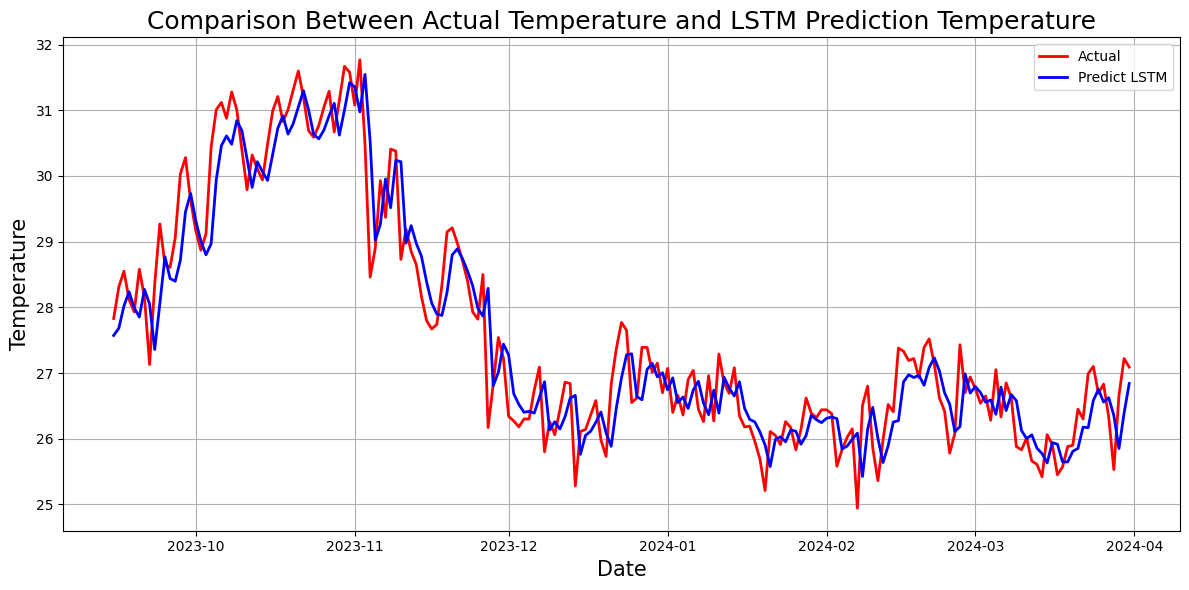

In [ ]:
# Plot data test LSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict LSTM'], label='Predict LSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and LSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('LSTM.pdf', format='pdf')
plt.show()

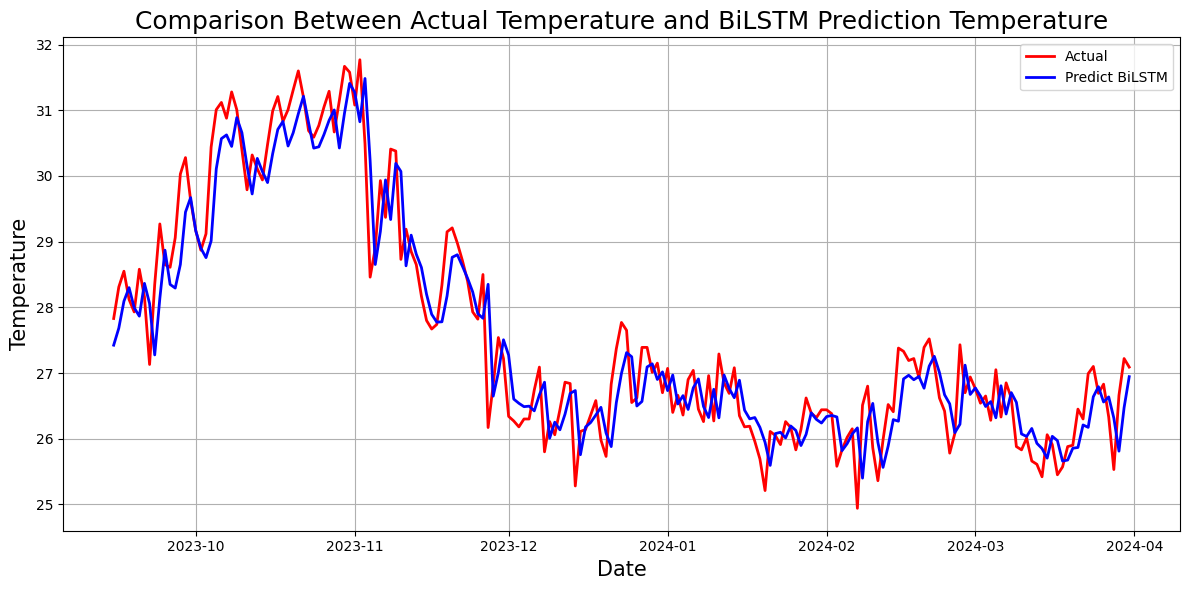

In [ ]:
# Plot data test BiLSTM
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiLSTM'], label='Predict BiLSTM', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiLSTM Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiLSTM.pdf', format='pdf')
plt.show()

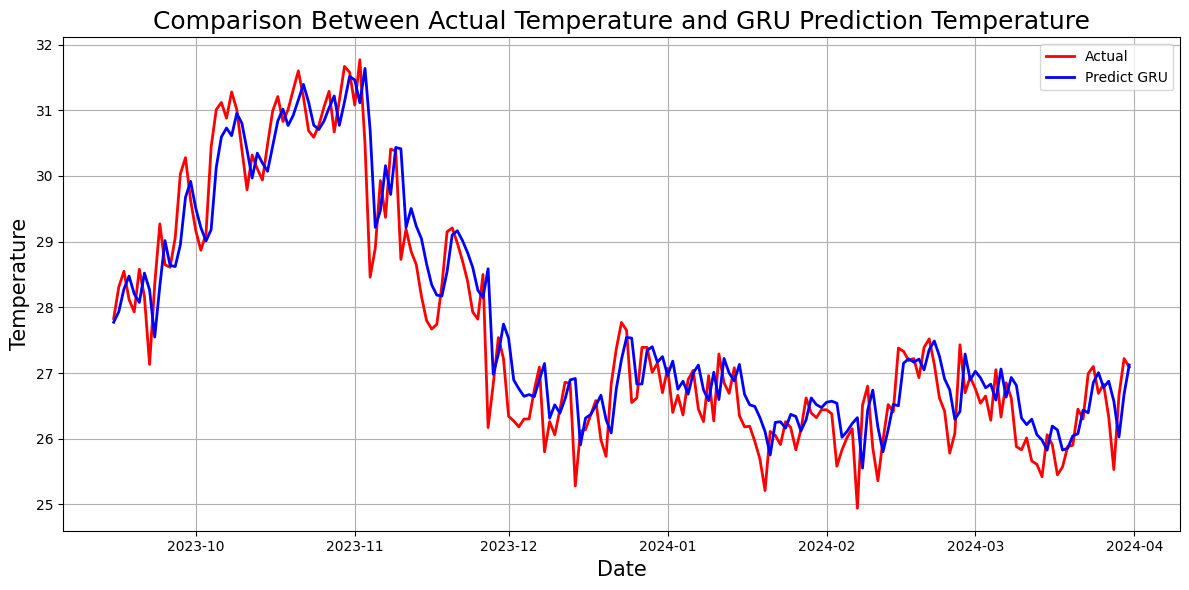

In [ ]:
# Plot data test GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict GRU'], label='Predict GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('GRU.pdf', format='pdf')
plt.show()

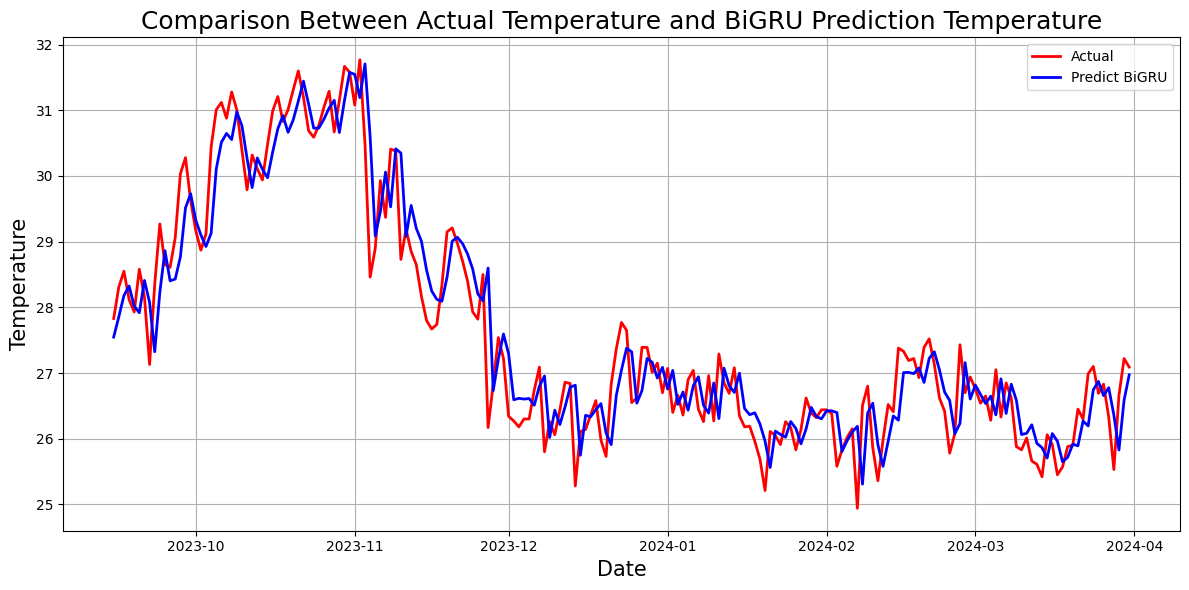

In [ ]:
# Plot data test BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict BiGRU'], label='Predict BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and BiGRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('BiGRU.pdf', format='pdf')
plt.show()

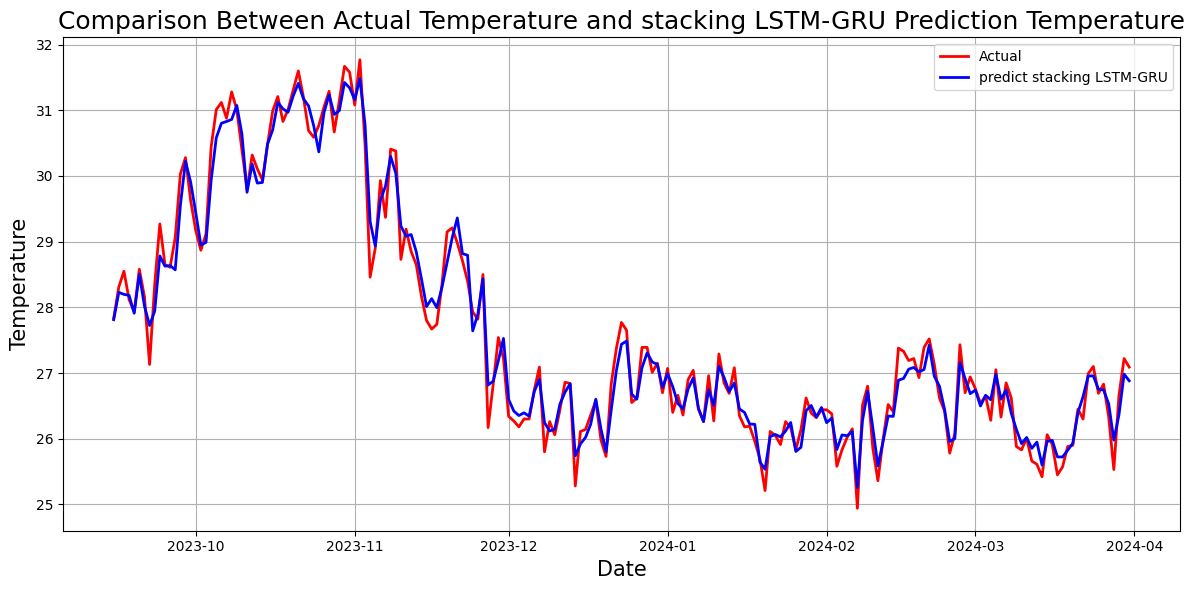

In [ ]:
# Plot data test LSTM-GRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking LSTM-GRU'], label='predict stacking LSTM-GRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking LSTM-GRU Prediction Temperature', fontsize=18)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking LSTM-GRU.pdf', format='pdf')
plt.show()

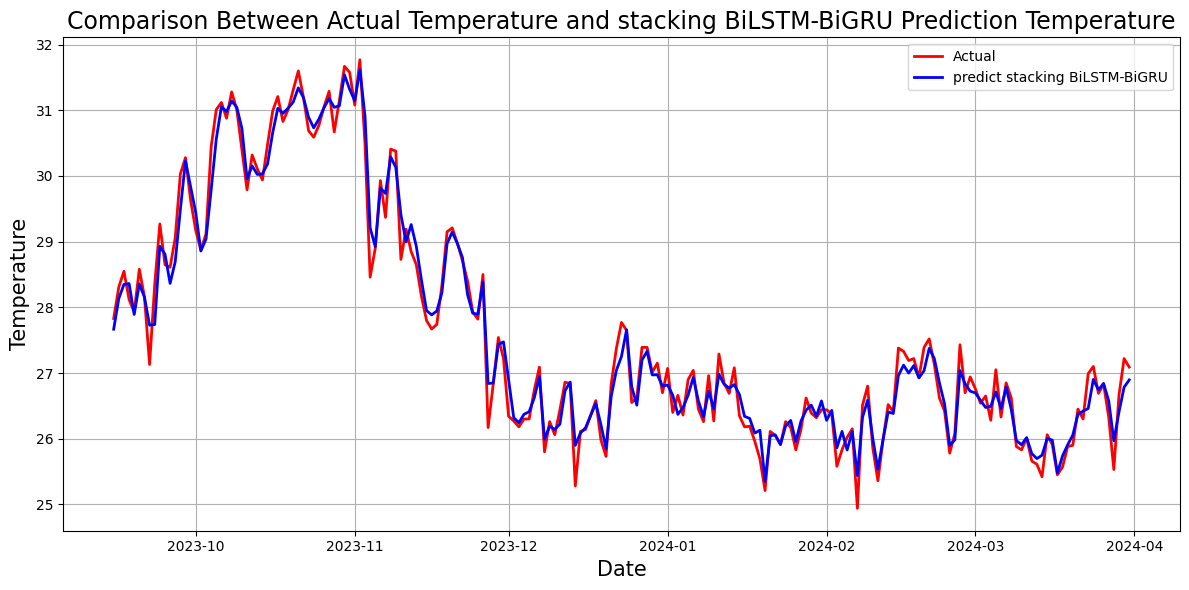

In [ ]:
# Plot data test BiLSTM-BiGRU
plt.figure(figsize=(12, 6))
plt.plot(df_merge['date'], df_merge['Actual'], label='Actual', color='red', linestyle='-', linewidth=2)
plt.plot(df_merge['date'], df_merge['predict stacking BiLSTM-BiGRU'], label='predict stacking BiLSTM-BiGRU', color='blue', linestyle='-', linewidth=2)

plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.title('Comparison Between Actual Temperature and stacking BiLSTM-BiGRU Prediction Temperature', fontsize=17)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig('stacking BiLSTM-BiGRU.pdf', format='pdf')
plt.show()

In [ ]:
excel_filename = 'real_predictions(30 hari).xlsx'
df_merge.to_excel(excel_filename, index=False)

In [ ]:
df_merge.set_index('date', inplace=True)

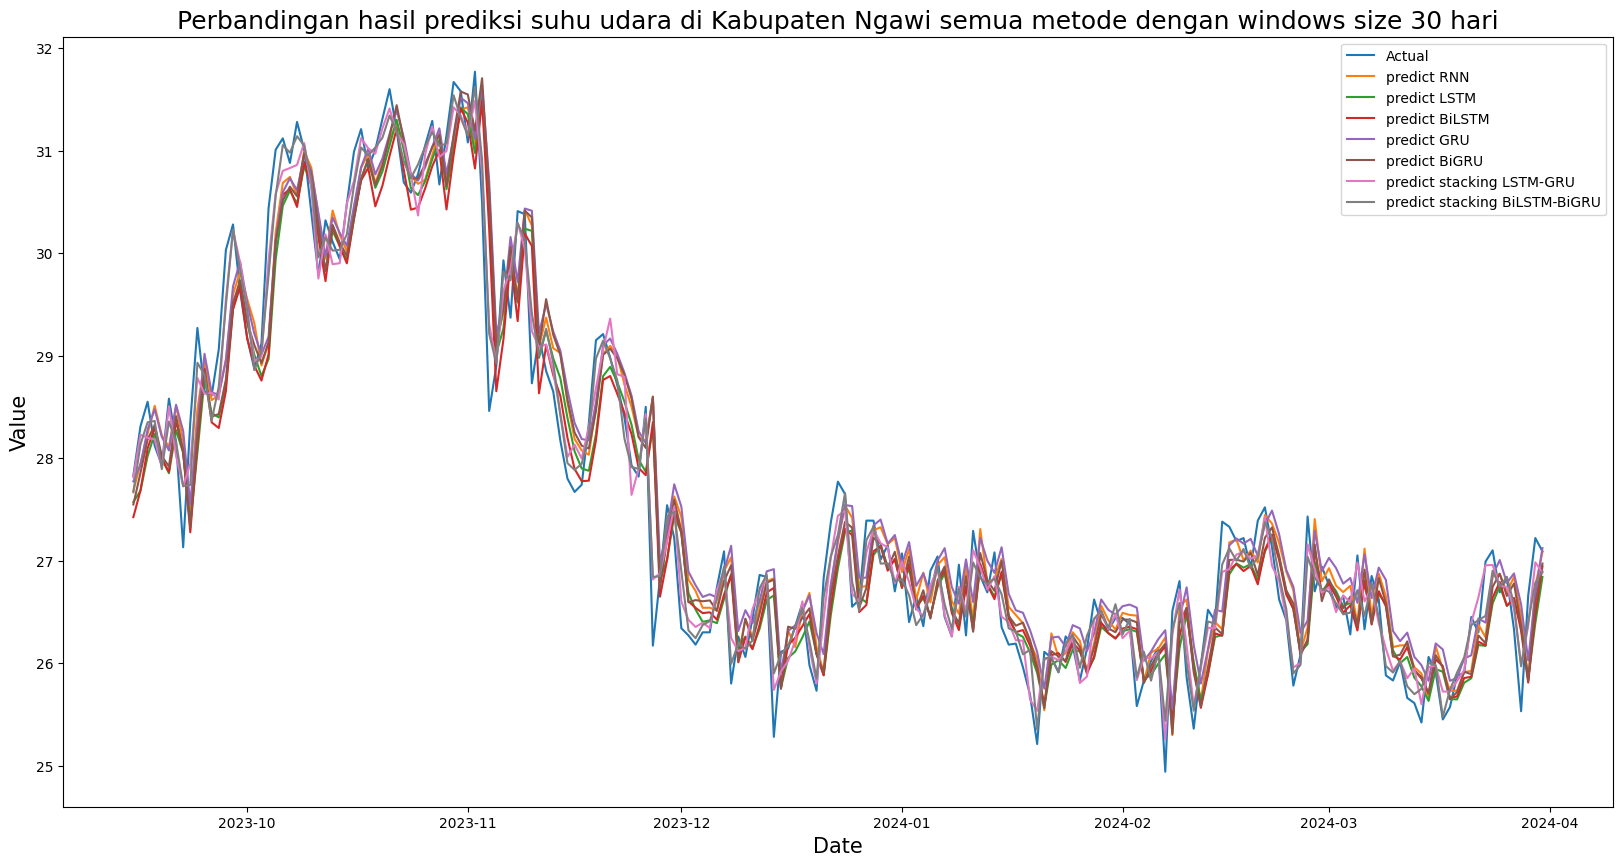

In [ ]:
# Membuat line plot dari semua kolom dengan keterangan
plt.figure(figsize=(20, 10))

for column in df_merge.columns:
    plt.plot(df_merge.index, df_merge[column], label=column)

# Menambahkan judul dan label sumbu
plt.title('Perbandingan hasil prediksi suhu udara di Kabupaten Ngawi semua metode dengan windows size 30 hari', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', fontsize=15)

# Menampilkan legend
plt.legend(loc='best')

# Simpan plot ke PDF
plt.savefig('semua metode.pdf', format='pdf')
plt.show()